# Welcome to the NoisePy Colab Tutorial!

This tutorial will walk you through the basic steps of using NoisePy to compute ambient noise cross correlation functions.


First, we install the noisepy-seis package

In [ ]:
# Uncomment and run this line if the environment doesn't have noisepy already installed:
# ! pip install noisepy-seis 

__Warning__: NoisePy uses ```obspy``` as a core Python module to manipulate seismic data. Restart the runtime now for proper installation of ```obspy``` on Colab.

Then we import the basic modules

In [1]:
from noisepy.seis import download, cross_correlate, stack_cross_correlations, plotting_modules, __version__
from noisepy.seis.asdfstore import ASDFRawDataStore, ASDFCCStore, ASDFStackStore
from noisepy.seis.datatypes import CCMethod, ConfigParameters, FreqNorm, TimeNorm
from dateutil.parser import isoparse
import os
import shutil
print(f"Using NoisePy version {__version__}")

path = os.path.join(".", "get_started_data")

os.makedirs(path,exist_ok=True)
raw_data_path = os.path.join(path, "RAW_DATA")
cc_data_path = os.path.join(path, "CCF")
stack_data_path = os.path.join(path, "STACK")

C:\Users\ishik\Desktop\Univ of Washington\RA Job\NoisePy\src\noisepy\seis\utils.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Using NoisePy version 0.1.dev641


## Ambient Noise Project Configuration

We store the metadata information about the ambient noise cross correlation workflow in a ConfigParameters() object. We first initialize it, then we tune the parameters for this cross correlation.

In [2]:
config = ConfigParameters() # default config parameters which can be customized
config.inc_hours = 12
config.samp_freq= 20  # (int) Sampling rate in Hz of desired processing (it can be different than the data sampling rate)
config.cc_len= 3600  # (float) basic unit of data length for fft (sec)
    # criteria for data selection
config.ncomp = 3  # 1 or 3 component data (needed to decide whether do rotation)


config.acorr_only = False  # only perform auto-correlation or not
config.xcorr_only = True  # only perform cross-correlation or not

config.inc_hours = 12 # if the data is first 

config.lamin = 31       # min latitude
config.lamax = 42       # max latitude
config.lomin = -124     # min longitude
config.lomax = -115     # max longitude
config.net_list = ["*"] # look for all network codes



 # pre-processing parameters
config.step= 1800.0  # (float) overlapping between each cc_len (sec)
config.stationxml= False  # station.XML file used to remove instrument response for SAC/miniseed data
config.rm_resp= "inv"  # select 'no' to not remove response and use 'inv' if you use the stationXML,'spectrum',
config.freqmin = 0.05
config.freqmax = 2.0
config.max_over_std  = 10  # threshold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# TEMPORAL and SPECTRAL NORMALISATION
config.freq_norm= FreqNorm.RMA # choose between "rma" for a soft whitenning or "no" for no whitening. Pure whitening is not implemented correctly at this point.
config.smoothspect_N = 10  # moving window length to smooth spectrum amplitude (points)
    # here, choose smoothspect_N for the case of a strict whitening (e.g., phase_only)

config.time_norm = TimeNorm.NO  # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain,
    # TODO: change time_norm option from "no" to "None"
config.smooth_N= 10  # moving window length for time domain normalization if selected (points)

config.cc_method= CCMethod.XCORR # 'xcorr' for pure cross correlation OR 'deconv' for deconvolution;
    # FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"

# OUTPUTS:
config.substack = True  # True = smaller stacks within the time chunk. False: it will stack over inc_hours
config.substack_len = config.cc_len  # how long to stack over (for monitoring purpose): need to be multiples of cc_len
    # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
    # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations

config.maxlag= 200  # lags of cross-correlation to save (sec)
config.substack = True

## Step 0: download data


This step will download data using obspy and save them into ASDF files locally. The data will be stored for each time chunk defined in hours by inc_hours.

The download will clean up the raw data by detrending, removing the mean, bandpassing (broadly), removing the instrumental response, merging gaps, ignoring too-gappy data.

Use the function ```download``` with the following arguments: 
* ```path```:where to put the data
* ```config```: configuration settings, in particular:
    * ```channel```: list of the seismic channels to download, and example is shown below
    * ```stations```: list of the seismic stations, it can be "\*" (not "all") 
    * ```start_time```
    * ```end_time```
* ```client_url_key```: the string for FDSN clients


In [3]:
config.stations = ["A*"]
config.channels =  ["BHE","BHN","BHZ"]
config.start_date =  isoparse("2019-02-01T00:00:00Z")
config.end_date = isoparse("2019-02-02T00:00:00Z")

# Download data locally. Enters raw data path, channel types, stations, config, and fdsn server.
download(raw_data_path, config)

2023-11-15 22:44:47,272 19268 INFO fdsn_download.download(): Download
        From: 2019-02-01T00:00:00.000000Z
        To: 2019-02-02T00:00:00.000000Z
        Stations: ['A*']
        Channels: ['BHE', 'BHN', 'BHZ']
        
2023-11-15 22:44:55,707 19268 INFO fdsn_download.download(): Fetched inventory
2023-11-15 22:44:55,707 19268 INFO utils.log_raw(): TIMING: 8.4355 secs. for Getting inventory
2023-11-15 22:44:55,723 19268 INFO fdsn_download.download(): Found 3 records for ADO in .\get_started_data\RAW_DATA\2019_02_01_00_00_00T2019_02_01_12_00_00.h5
2023-11-15 22:44:55,723 19268 INFO fdsn_download.download(): Found 3 records for ADO in .\get_started_data\RAW_DATA\2019_02_01_00_00_00T2019_02_01_12_00_00.h5
2023-11-15 22:44:55,723 19268 INFO fdsn_download.download(): Found 3 records for ADO in .\get_started_data\RAW_DATA\2019_02_01_00_00_00T2019_02_01_12_00_00.h5
2023-11-15 22:44:55,739 19268 INFO fdsn_download.download(): Found 3 records for ALP in .\get_started_data\RAW_DATA\2019_02

List the files that were downloaded, just to make sure !

In [4]:
print(os.listdir(raw_data_path))

['2019_02_01_00_00_00T2019_02_01_12_00_00.h5', '2019_02_01_12_00_00T2019_02_02_00_00_00.h5', 'station.csv']


Plot the raw data, make sure it's noise!

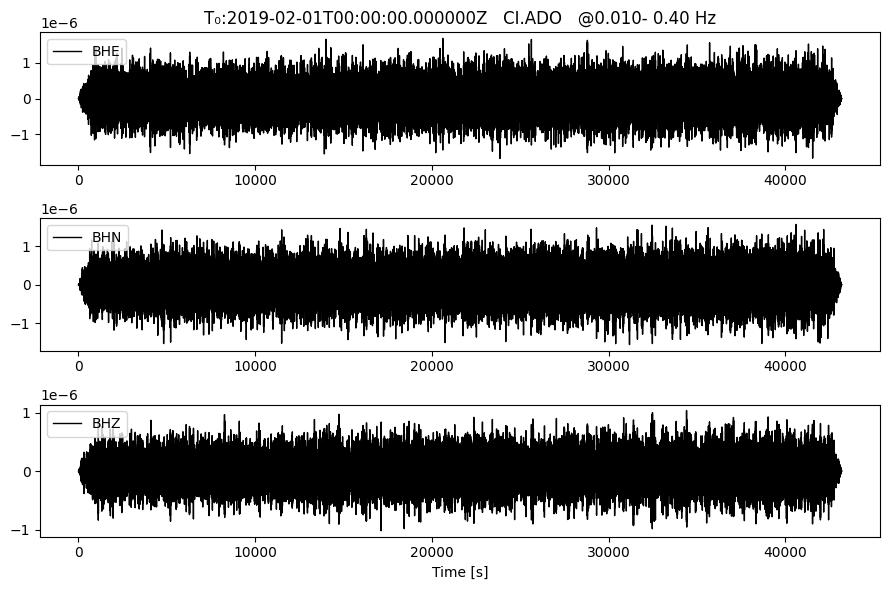

In [5]:
file = os.path.join(raw_data_path, "2019_02_01_00_00_00T2019_02_01_12_00_00.h5")
plotting_modules.plot_waveform(file,'CI','ADO',0.01,0.4) # this function takes for input: filename, network, station, freqmin, freqmax for a bandpass filter

## Step 1: Cross-correlation

This step will perform the cross correlation. For each time chunk, it will read the data, perform classic ambient noise pre-processing (time and frequency normalization), FFT, cross correlation, substacking, saving cross correlations in to a temp ASDF file (this is not fast and will be improved).


In [6]:
# For this tutorial make sure the previous run is empty
shutil.rmtree(cc_data_path)

'c:\\Users\\ishik\\Desktop\\Univ of Washington\\RA Job\\NoisePy\\tutorials'

In [7]:
config.freq_norm = FreqNorm.RMA
raw_store = ASDFRawDataStore(raw_data_path) # Store for reading raw data
cc_store = ASDFCCStore(cc_data_path) # Store for writing CC data

# print the configuration parameters. Some are chosen by default but we cab modify them
print(config)

client_url_key='SCEDC' start_date=datetime.datetime(2019, 2, 1, 0, 0, tzinfo=tzutc()) end_date=datetime.datetime(2019, 2, 2, 0, 0, tzinfo=tzutc()) samp_freq=20 single_freq=True cc_len=3600 lamin=31 lamax=42 lomin=-124 lomax=-115 down_list=False net_list=['*'] stations=['A*'] channels=['BHE', 'BHN', 'BHZ'] step=1800.0 freqmin=0.05 freqmax=2.0 freq_norm=<FreqNorm.RMA: 'rma'> time_norm=<TimeNorm.NO: 'no'> cc_method=<CCMethod.XCORR: 'xcorr'> smooth_N=10 smoothspect_N=10 substack=True substack_len=3600 maxlag=200 inc_hours=12 max_over_std=10 ncomp=3 stationxml=False rm_resp='inv' rm_resp_out='VEL' respdir=None acorr_only=False xcorr_only=True stack_method=<StackMethod.LINEAR: 'linear'> keep_substack=False rotation=True correction=False correction_csv=None storage_options=defaultdict(<class 'dict'>, {})


Perform the cross correlation

In [8]:
cross_correlate(raw_store, config, cc_store)

2023-11-15 22:45:30,170 19268 INFO correlate.cross_correlate(): Starting Cross-Correlation with 12 cores
2023-11-15 22:45:30,249 19268 INFO utils.log_raw(): TIMING CC Main: 0.0792 secs. for get 12 channels
2023-11-15 22:45:30,249 19268 INFO correlate.cc_timespan(): Checking for stations already done: 10 pairs
2023-11-15 22:45:30,249 19268 INFO utils.log_raw(): TIMING CC Main: 0.0000 secs. for check for 4 stations already done (warm up cache)
2023-11-15 22:45:30,265 19268 INFO utils.log_raw(): TIMING CC Main: 0.0164 secs. for check for stations already done
2023-11-15 22:45:30,270 19268 INFO correlate.cc_timespan(): Still need to process: 4/4 stations, 12/12 channels, 10/10 pairs for 2019-02-01T00:00:00+0000 - 2019-02-01T12:00:00+0000


Read channel data:   0%|          | 0/12 [00:00<?, ?it/s]

2023-11-15 22:45:30,911 19268 INFO correlate._filter_channel_data(): Picked 20.0 as the closest sampling frequence to 20.0. 
2023-11-15 22:45:30,911 19268 INFO correlate._filter_channel_data(): Filtered to 12/12 channels with sampling rate == 20.0
2023-11-15 22:45:30,914 19268 INFO utils.log_raw(): TIMING CC Main: 0.6484 secs. for Read channel data: 12 channels


Pre-process:   0%|          | 0/12 [00:00<?, ?it/s]

2023-11-15 22:45:31,312 11916 INFO noise_module.preprocess_raw(): removing response for CI.ADO..BHE | 2019-02-01T00:00:00.000000Z - 2019-02-01T12:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:31,351 2884 INFO noise_module.preprocess_raw(): removing response for CI.ALP..BHZ | 2019-02-01T00:00:00.000000Z - 2019-02-01T12:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:31,452 26676 INFO noise_module.preprocess_raw(): removing response for CI.ARV..BHE | 2019-02-01T00:00:00.000000Z - 2019-02-01T12:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:31,481 34928 INFO noise_module.preprocess_raw(): removing response for CI.AVM..BHE | 2019-02-01T00:00:00.000000Z - 2019-02-01T12:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:31,483 22176 INFO noise_module.preprocess_raw(): removing response for CI.ALP..BHE | 2019-02-01T00:00:00.000000Z - 2019-02-01T12:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:31,4

Compute ffts:   0%|          | 0/12 [00:00<?, ?it/s]

2023-11-15 22:45:36,165 19268 INFO utils.log_raw(): TIMING CC Main: 0.9669 secs. for Compute FFTs: 12 channels
2023-11-15 22:45:36,165 19268 INFO correlate.cc_timespan(): Starting CC with 10 station pairs


Cross correlation:   0%|          | 0/10 [00:00<?, ?it/s]

Save correlations:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-15 22:45:39,575 19268 INFO utils.log_raw(): TIMING CC Main: 3.4099 secs. for Correlate and write to store
2023-11-15 22:45:39,682 19268 INFO utils.log_raw(): TIMING CC Main: 9.5121 secs. for Process the chunk of 2019-02-01T00:00:00+0000 - 2019-02-01T12:00:00+0000
2023-11-15 22:45:39,750 19268 INFO utils.log_raw(): TIMING CC Main: 0.0561 secs. for get 12 channels
2023-11-15 22:45:39,751 19268 INFO correlate.cc_timespan(): Checking for stations already done: 10 pairs
2023-11-15 22:45:39,754 19268 INFO utils.log_raw(): TIMING CC Main: 0.0031 secs. for check for 4 stations already done (warm up cache)
2023-11-15 22:45:39,756 19268 INFO utils.log_raw(): TIMING CC Main: 0.0020 secs. for check for stations already done
2023-11-15 22:45:39,759 19268 INFO correlate.cc_timespan(): Still need to process: 4/4 stations, 12/12 channels, 10/10 pairs for 2019-02-01T12:00:00+0000 - 2019-02-02T00:00:00+0000


Read channel data:   0%|          | 0/12 [00:00<?, ?it/s]

2023-11-15 22:45:40,369 19268 INFO correlate._filter_channel_data(): Picked 20.0 as the closest sampling frequence to 20.0. 
2023-11-15 22:45:40,369 19268 INFO correlate._filter_channel_data(): Filtered to 12/12 channels with sampling rate == 20.0
2023-11-15 22:45:40,369 19268 INFO utils.log_raw(): TIMING CC Main: 0.6128 secs. for Read channel data: 12 channels


Pre-process:   0%|          | 0/12 [00:00<?, ?it/s]

2023-11-15 22:45:40,712 1312 INFO noise_module.preprocess_raw(): removing response for CI.ADO..BHE | 2019-02-01T12:00:00.000000Z - 2019-02-02T00:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:40,821 25532 INFO noise_module.preprocess_raw(): removing response for CI.ALP..BHE | 2019-02-01T12:00:00.000000Z - 2019-02-02T00:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:40,837 18772 INFO noise_module.preprocess_raw(): removing response for CI.ADO..BHN | 2019-02-01T12:00:00.000000Z - 2019-02-02T00:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:40,837 25716 INFO noise_module.preprocess_raw(): removing response for CI.AVM..BHZ | 2019-02-01T12:00:00.000000Z - 2019-02-02T00:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:40,837 13600 INFO noise_module.preprocess_raw(): removing response for CI.ALP..BHZ | 2019-02-01T12:00:00.000000Z - 2019-02-02T00:00:00.000000Z | 20.0 Hz, 864001 samples using inv
2023-11-15 22:45:40,9

Compute ffts:   0%|          | 0/12 [00:00<?, ?it/s]

2023-11-15 22:45:45,418 19268 INFO utils.log_raw(): TIMING CC Main: 0.8707 secs. for Compute FFTs: 12 channels
2023-11-15 22:45:45,418 19268 INFO correlate.cc_timespan(): Starting CC with 10 station pairs


Cross correlation:   0%|          | 0/10 [00:00<?, ?it/s]

Save correlations:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-15 22:45:48,462 19268 INFO utils.log_raw(): TIMING CC Main: 3.0443 secs. for Correlate and write to store
2023-11-15 22:45:48,575 19268 INFO utils.log_raw(): TIMING CC Main: 8.8817 secs. for Process the chunk of 2019-02-01T12:00:00+0000 - 2019-02-02T00:00:00+0000
2023-11-15 22:45:48,594 19268 INFO utils.log_raw(): TIMING CC Main: 18.4242 secs. for Step 1 in total with 12 cores


Plot a single set of the cross correlation

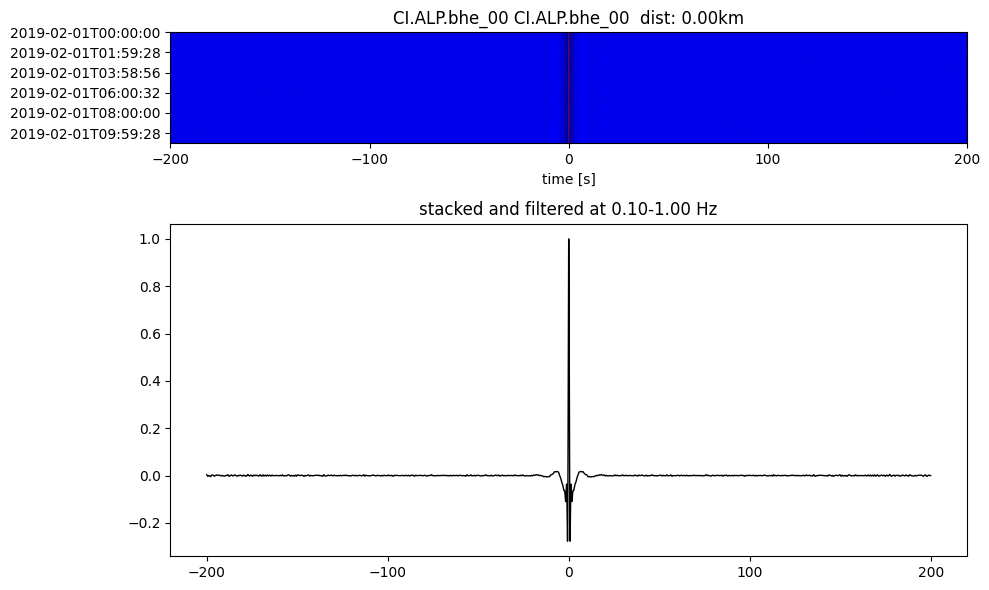

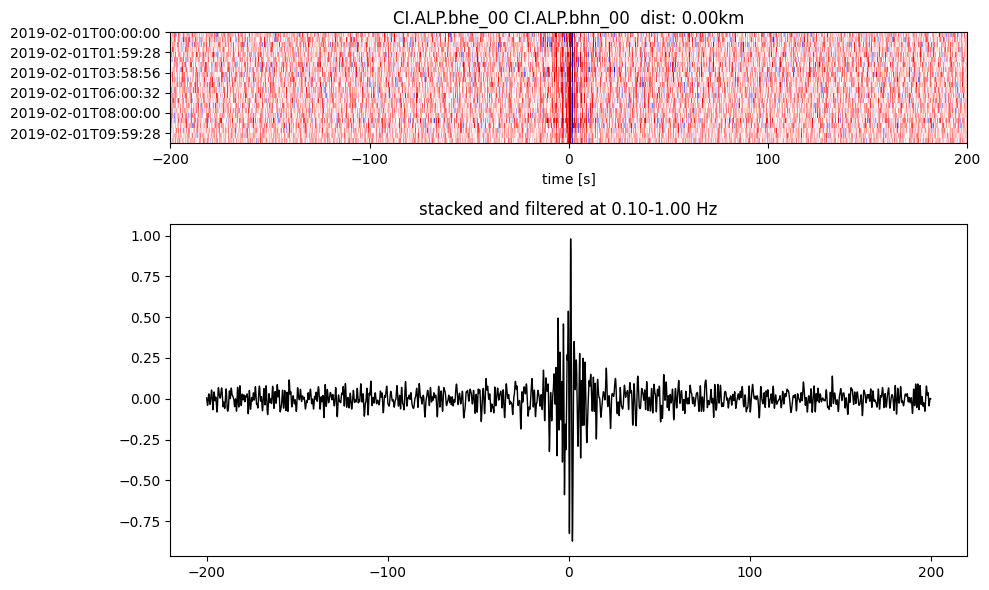

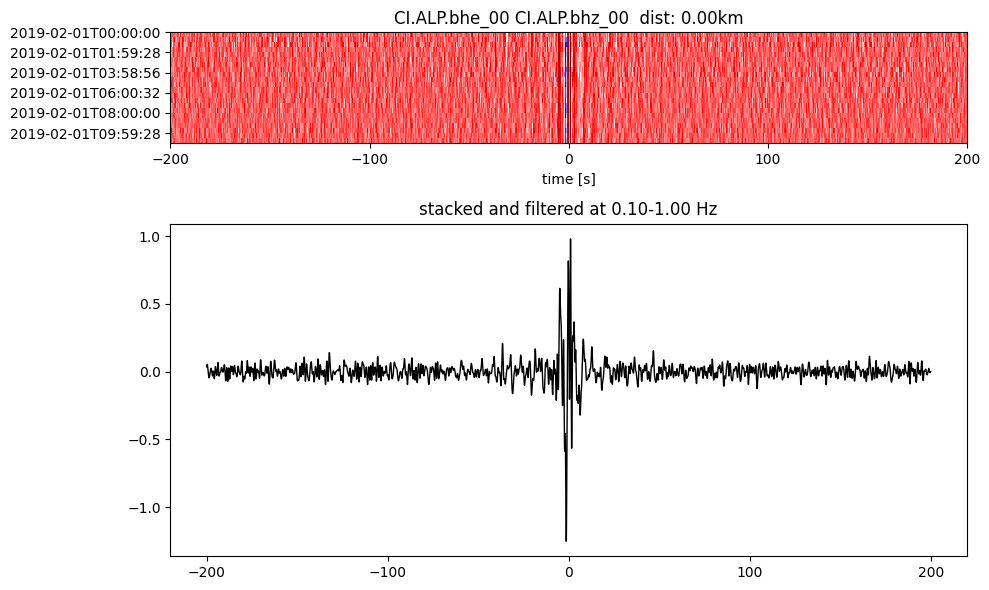

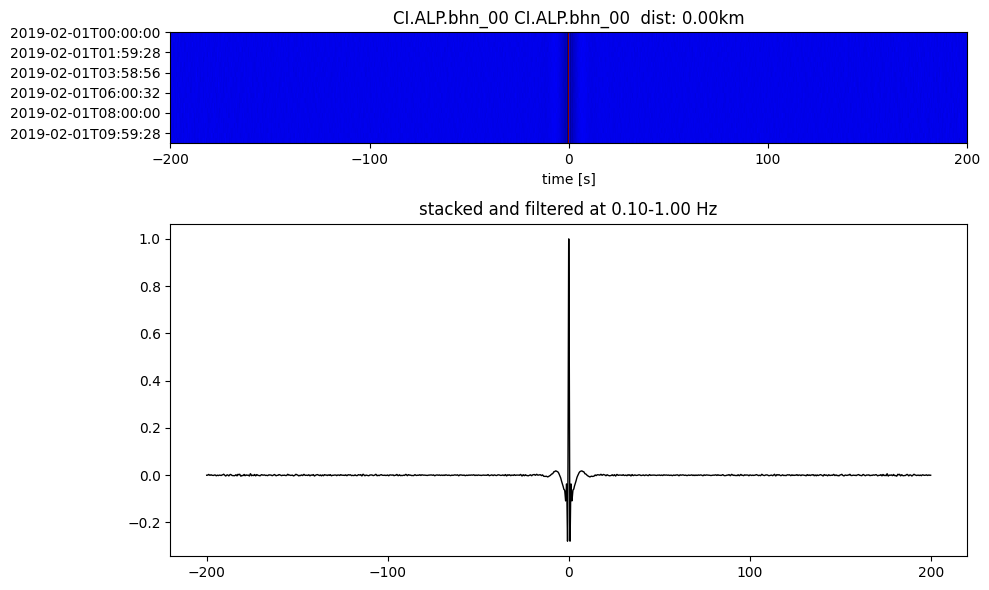

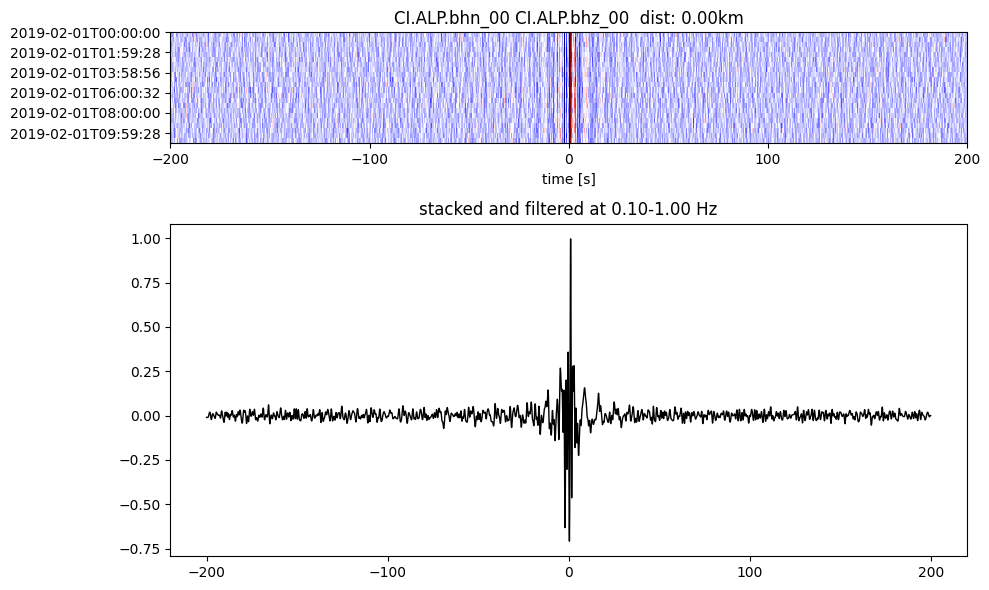

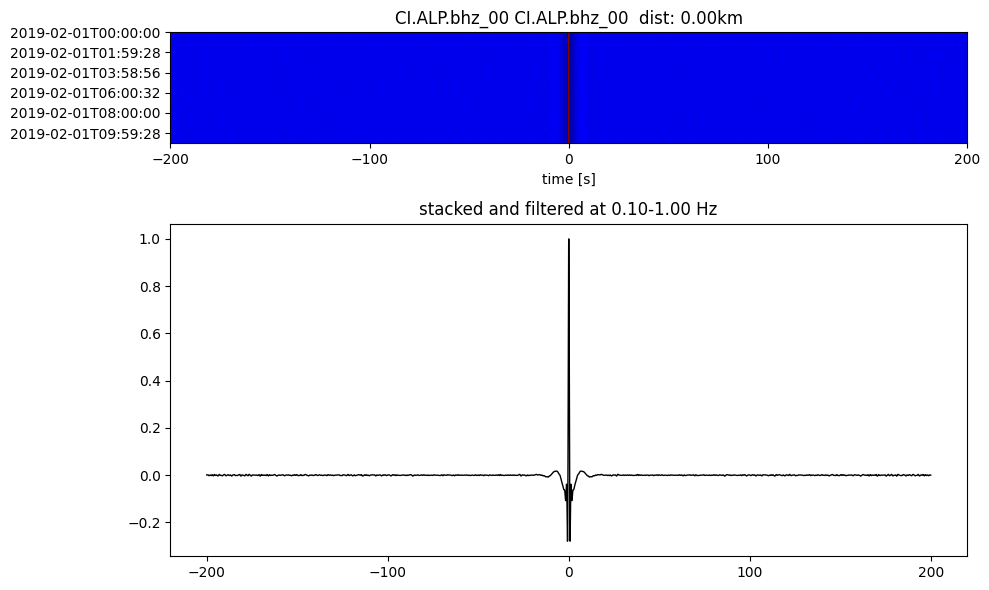

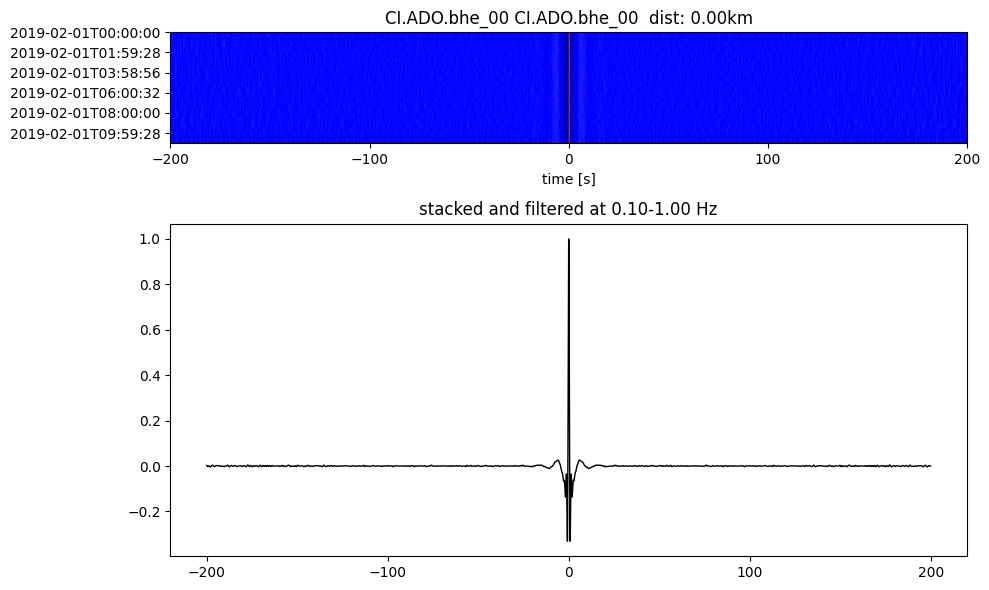

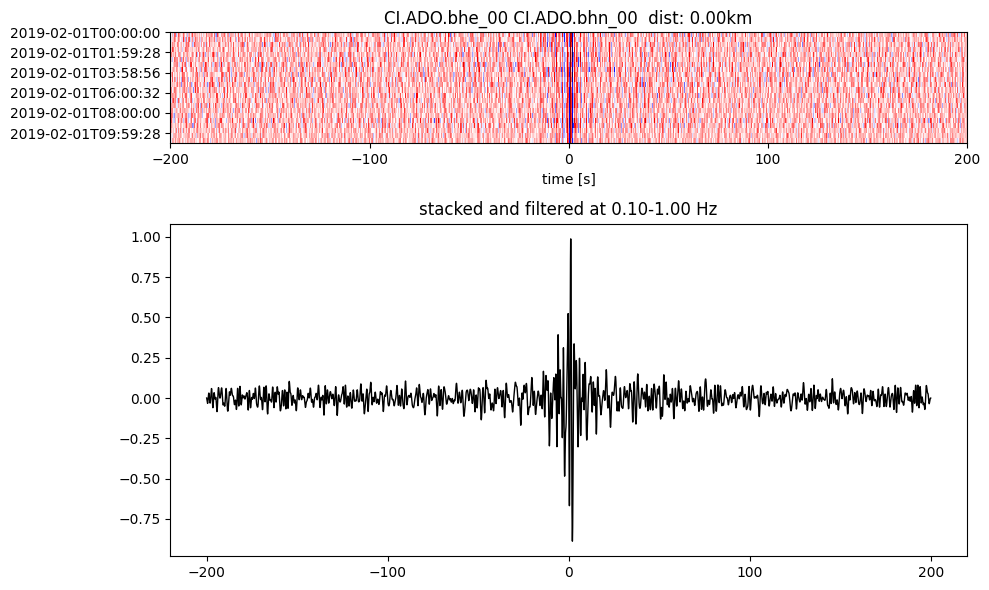

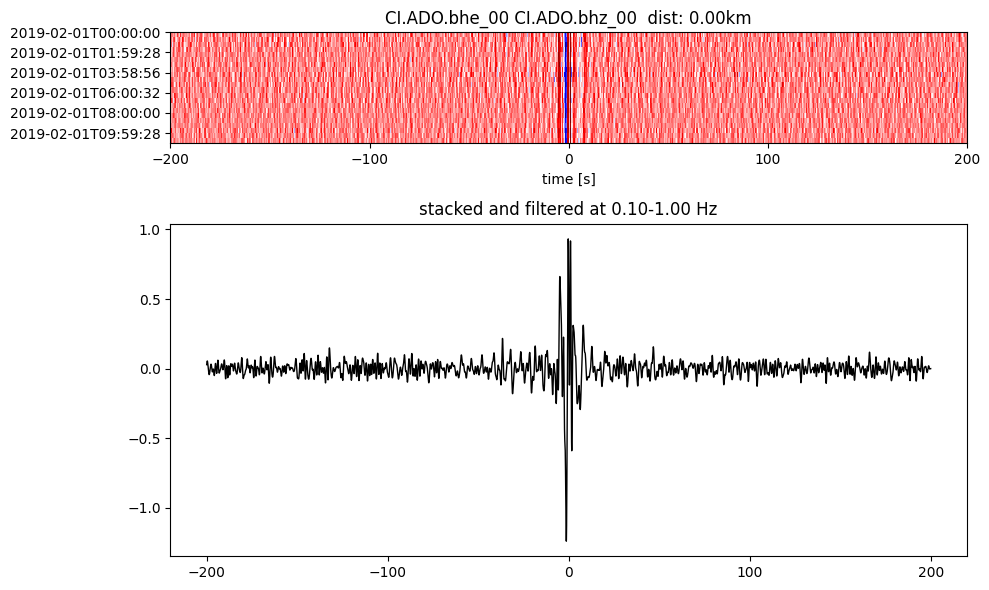

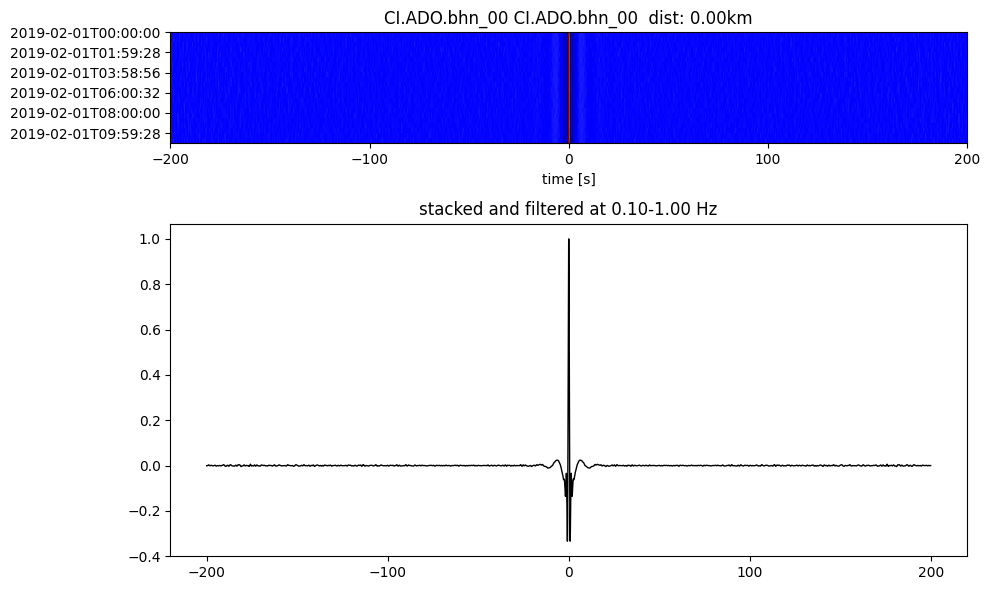

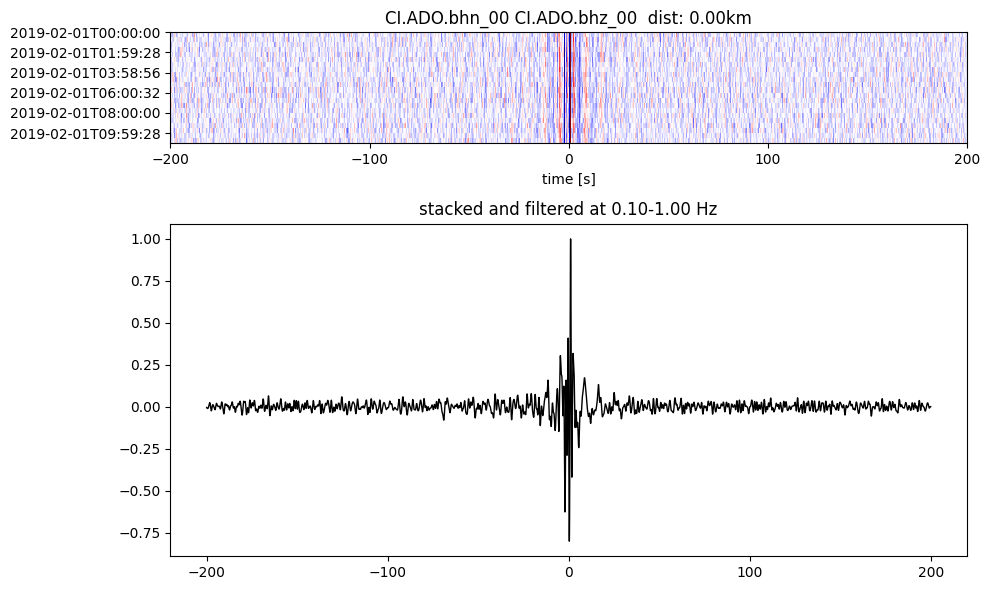

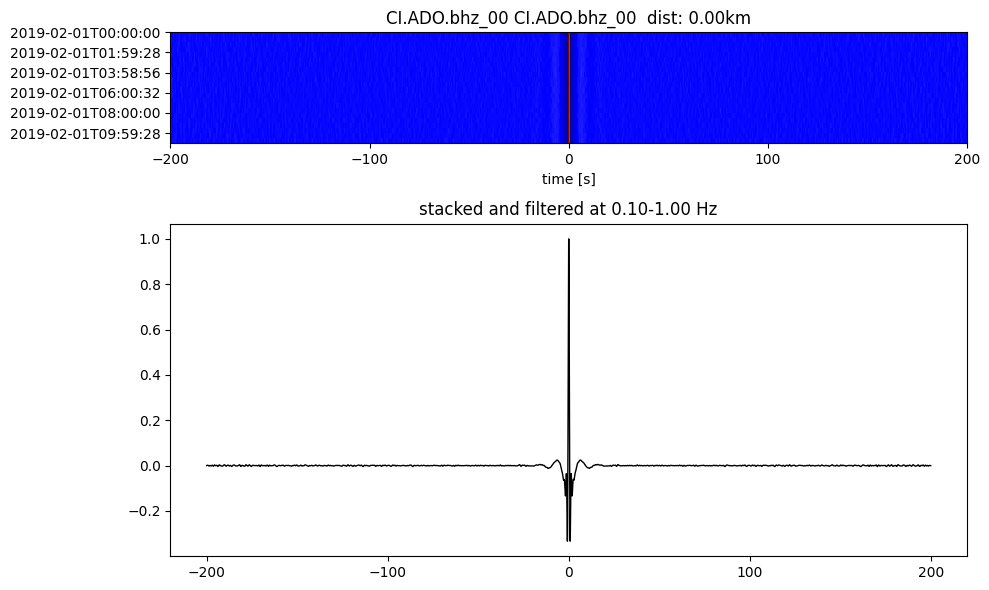

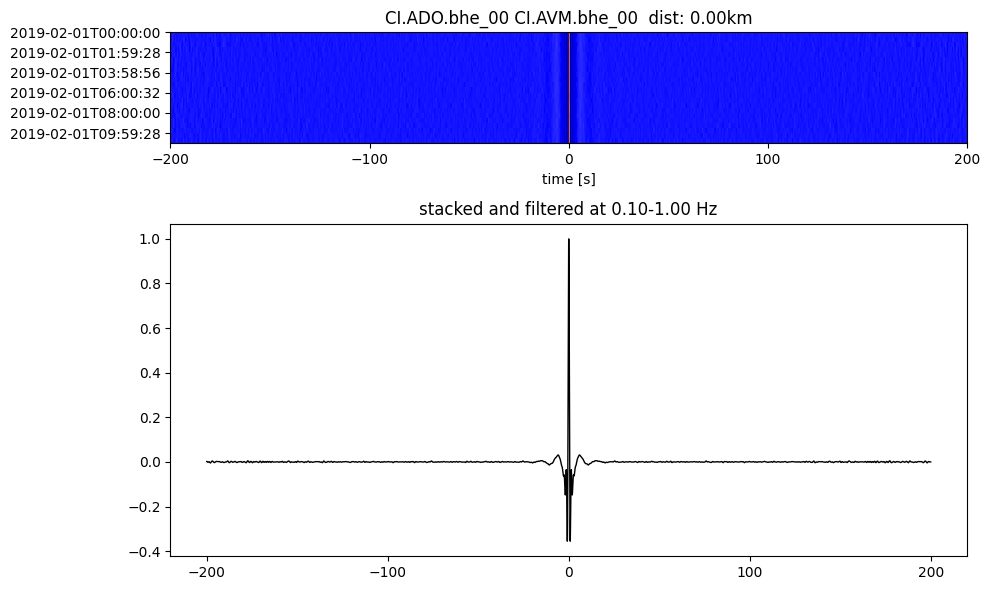

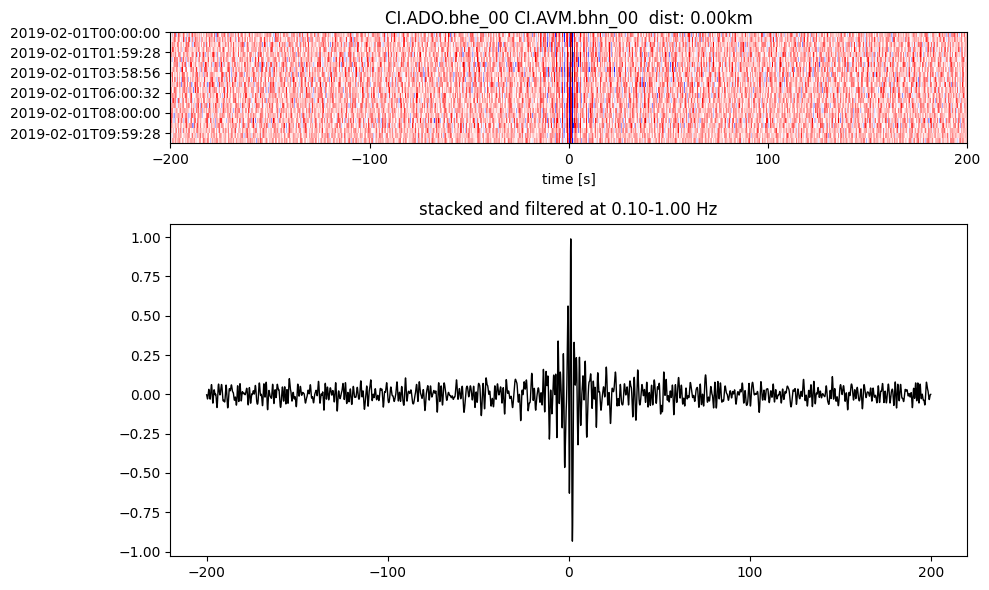

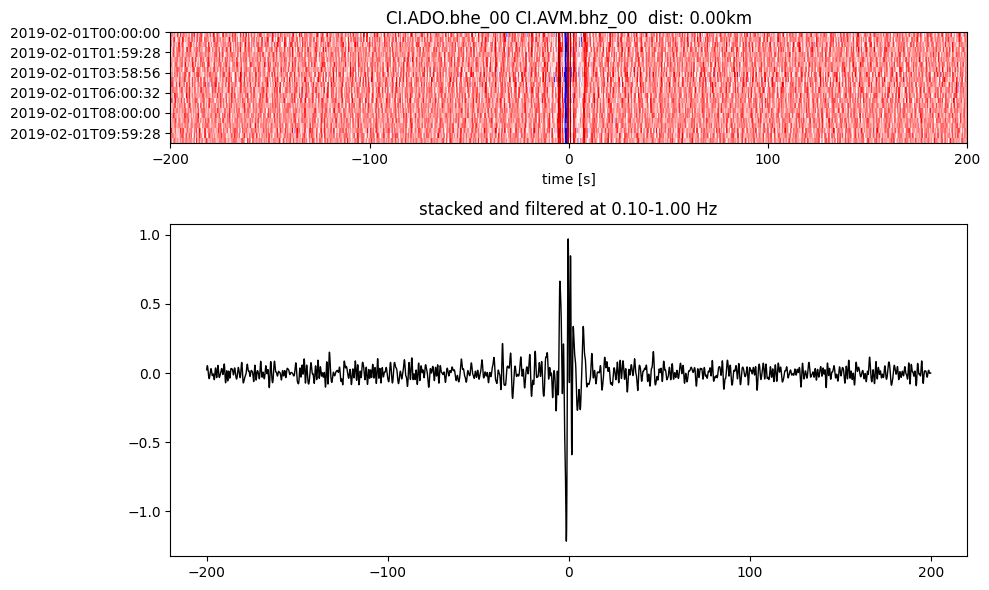

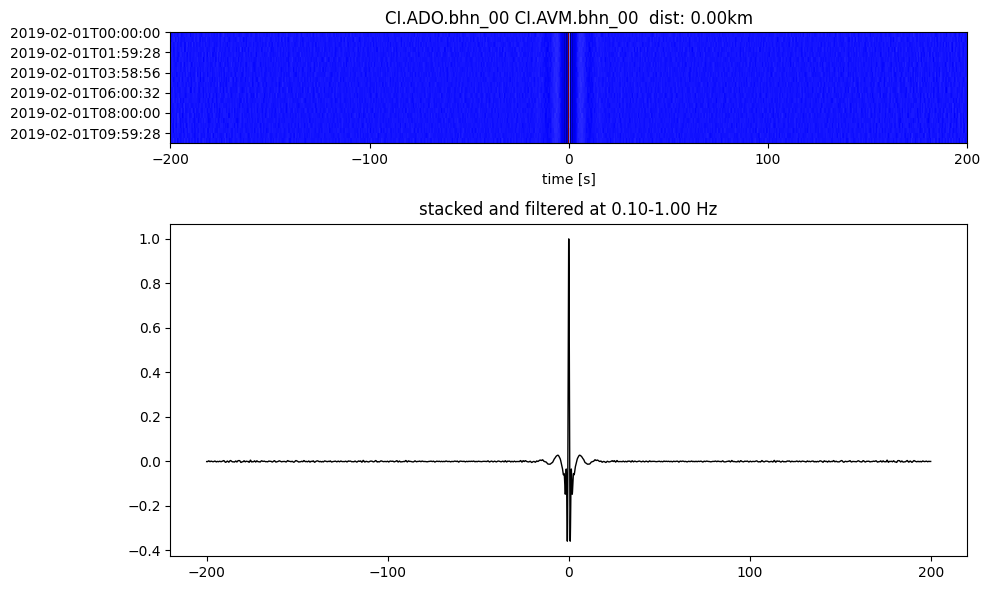

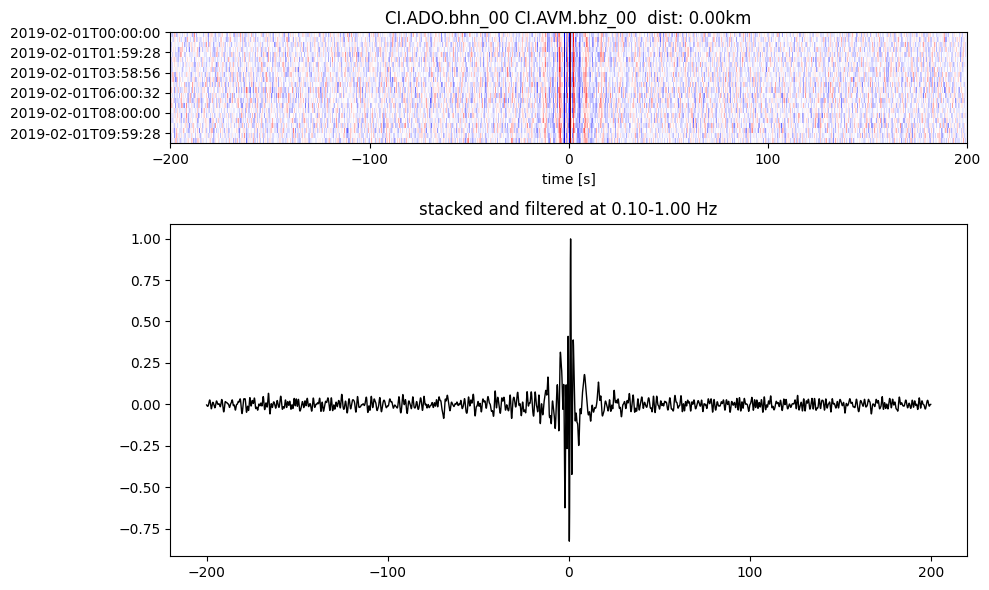

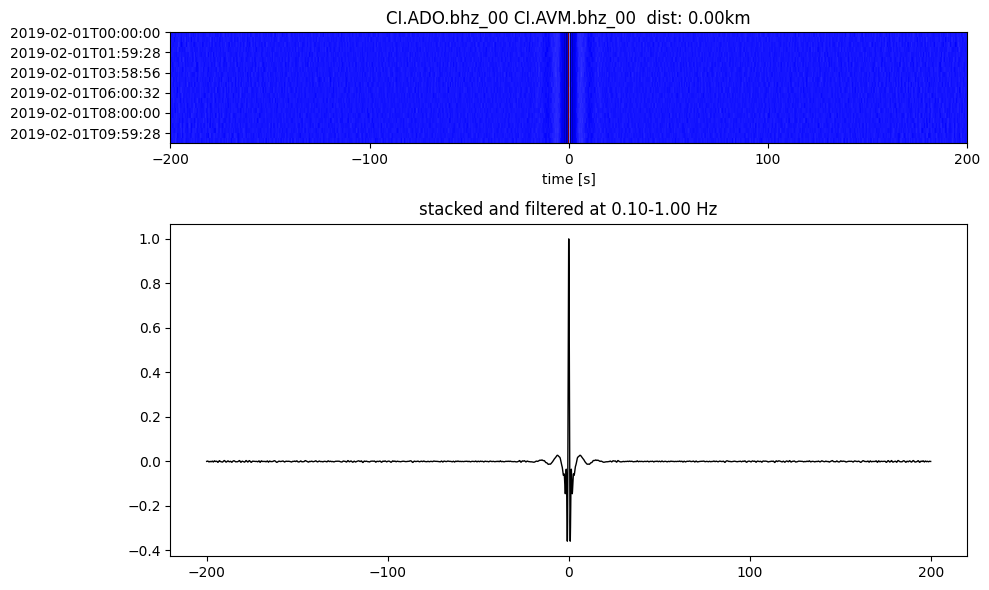

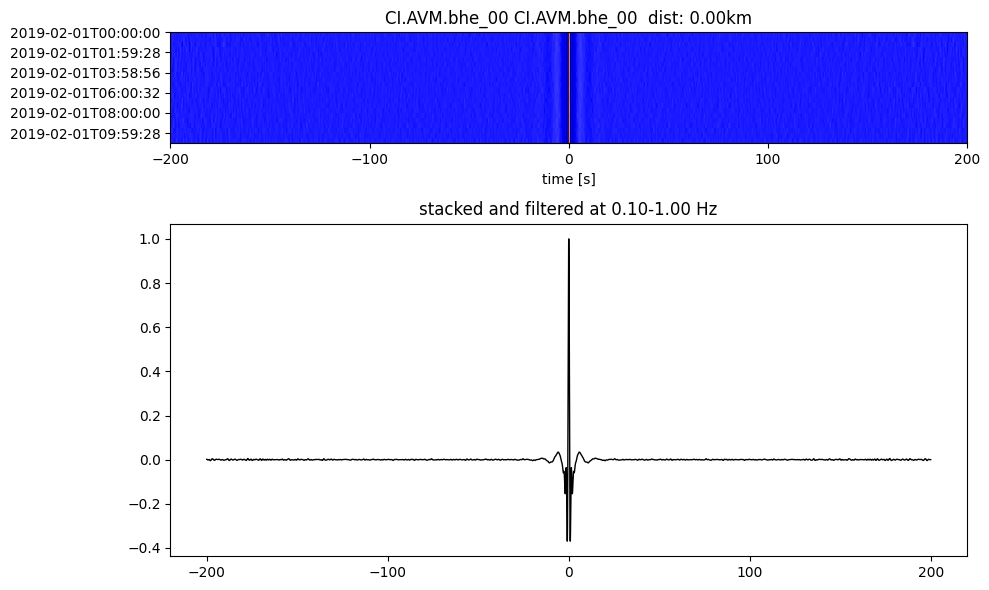

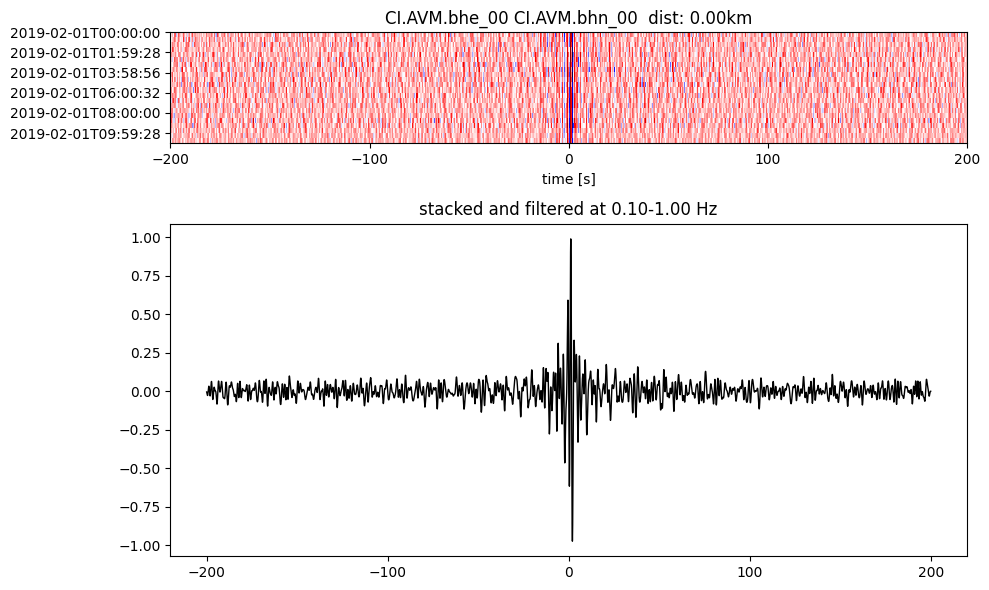

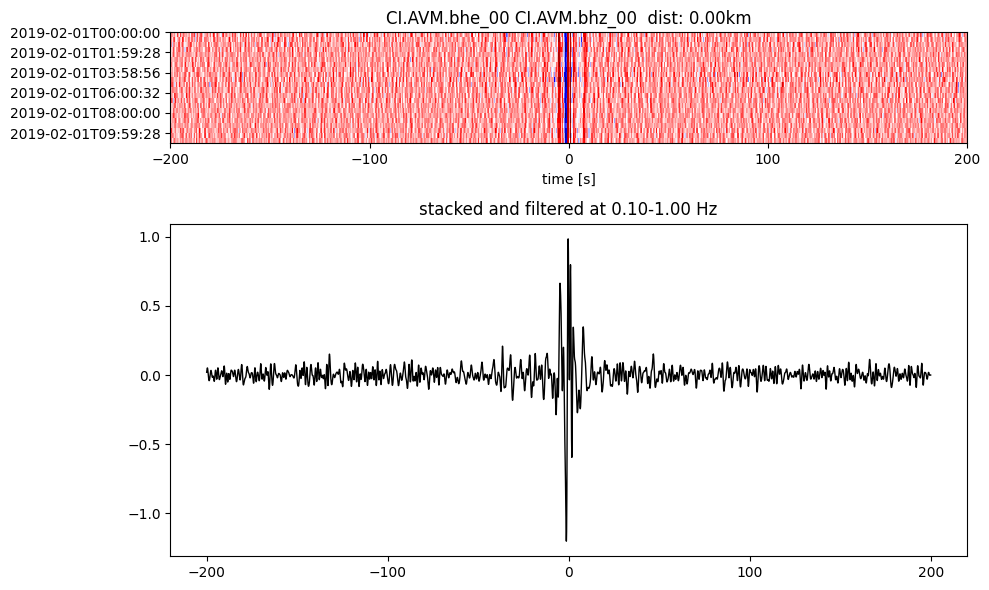

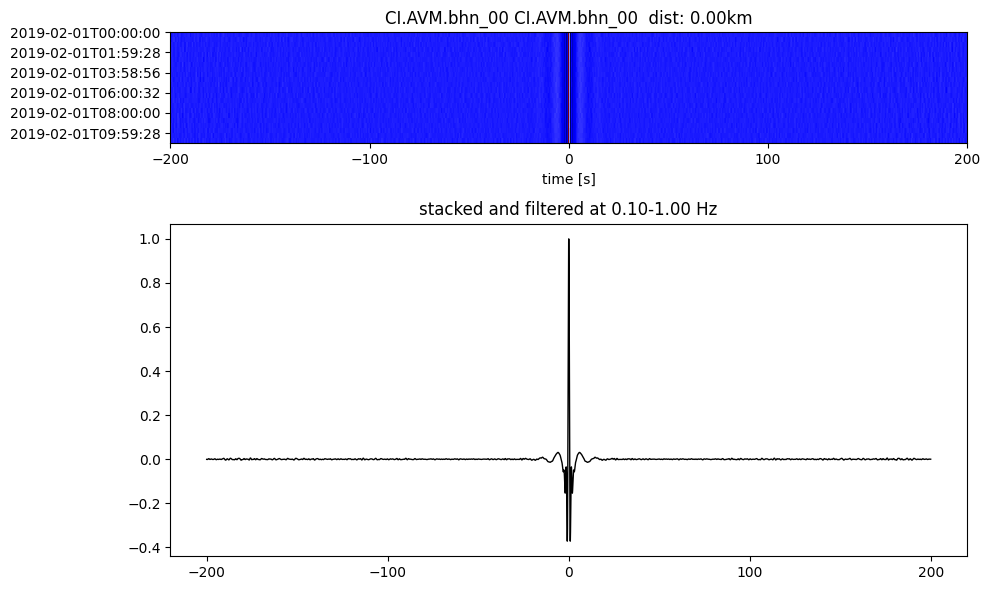

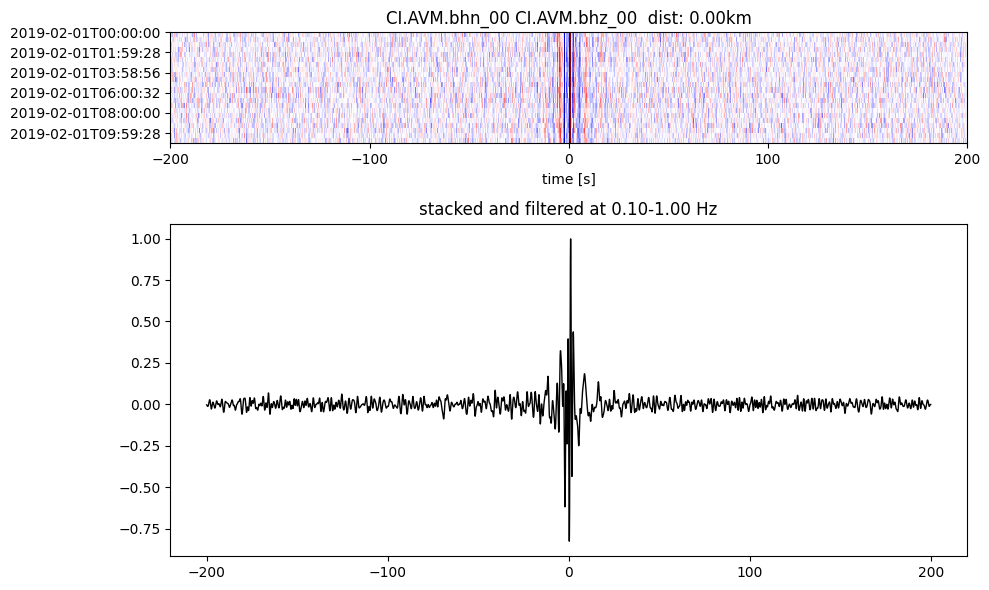

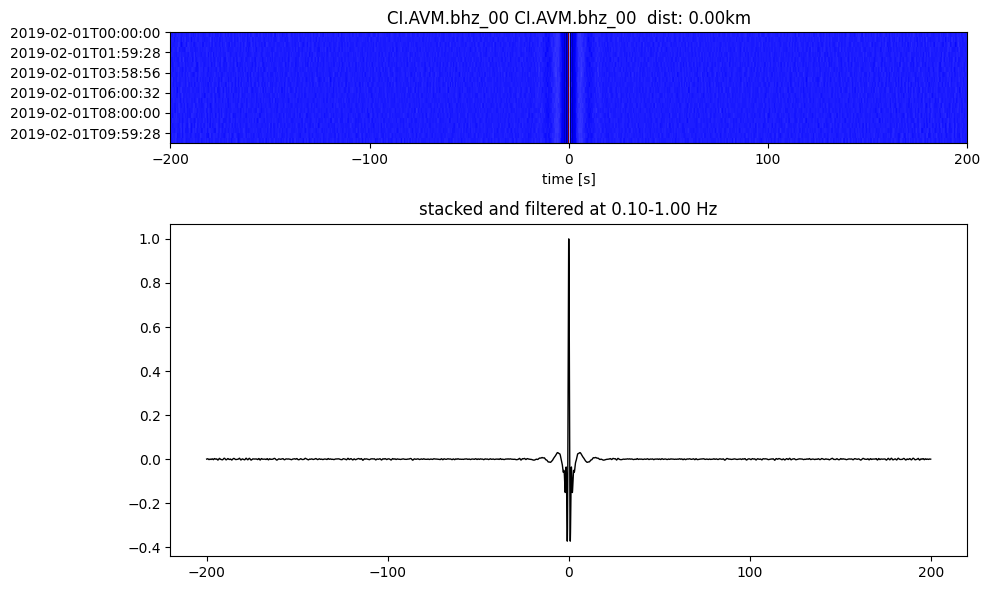

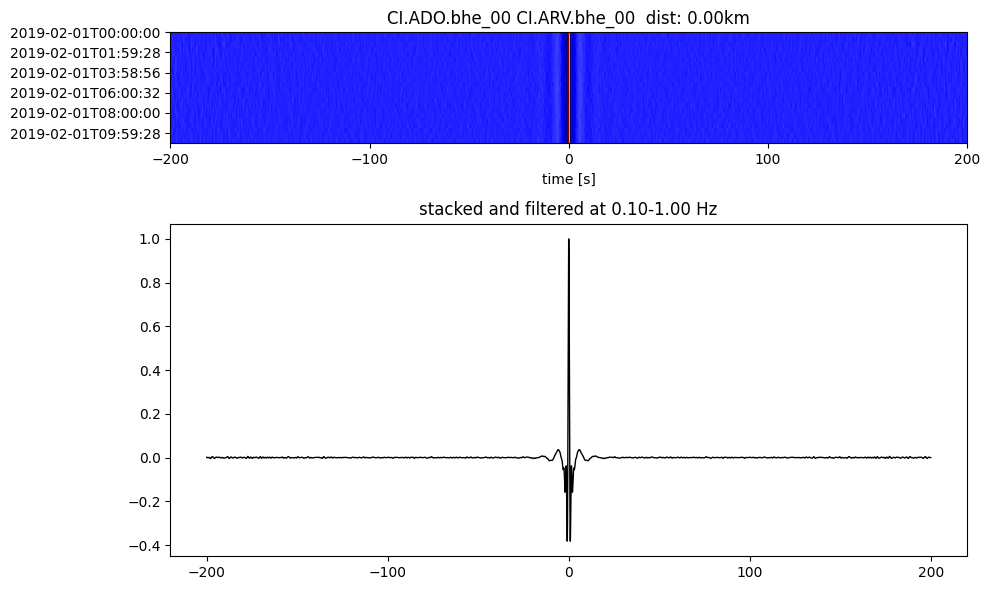

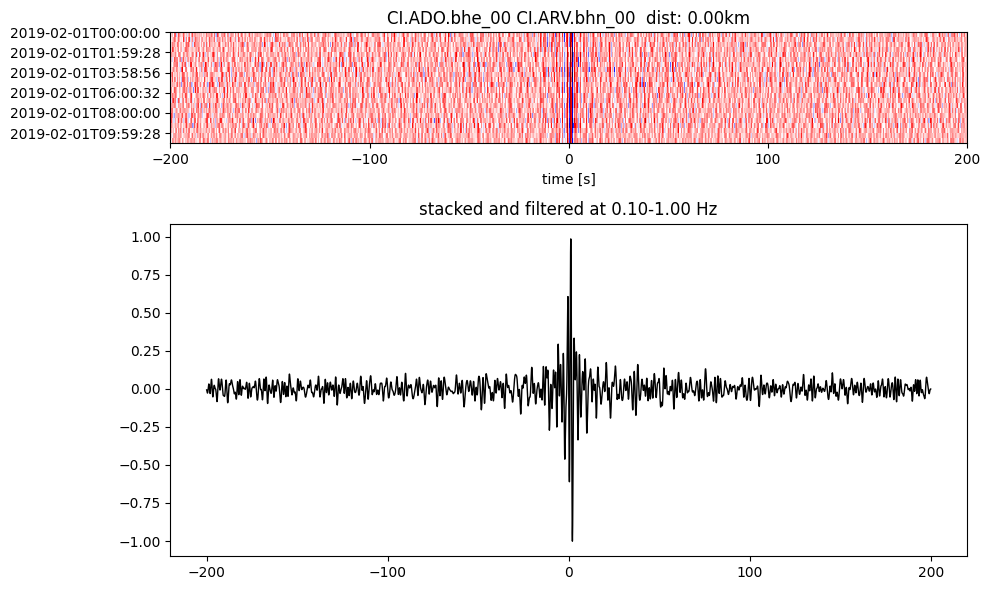

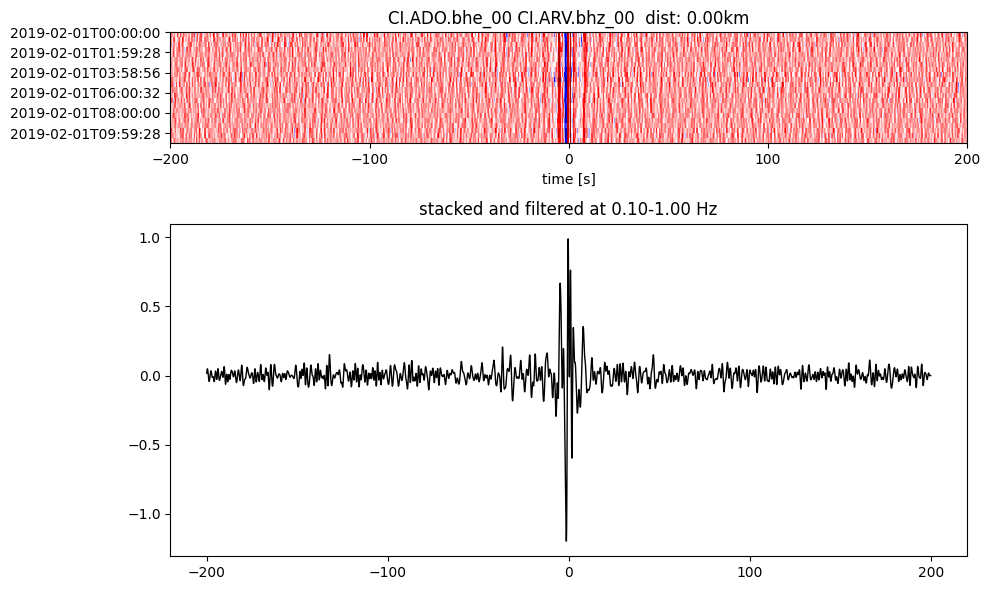

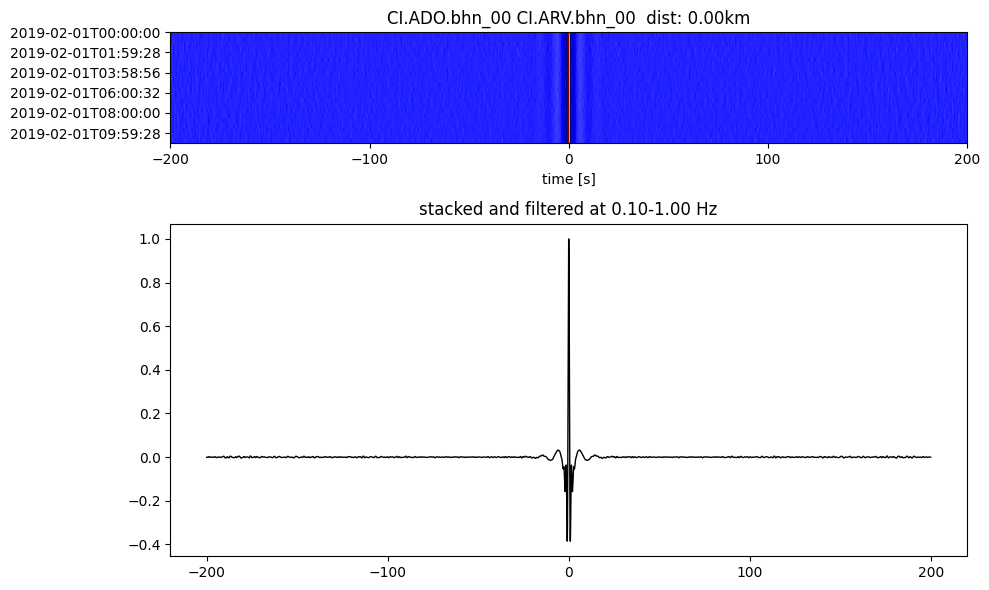

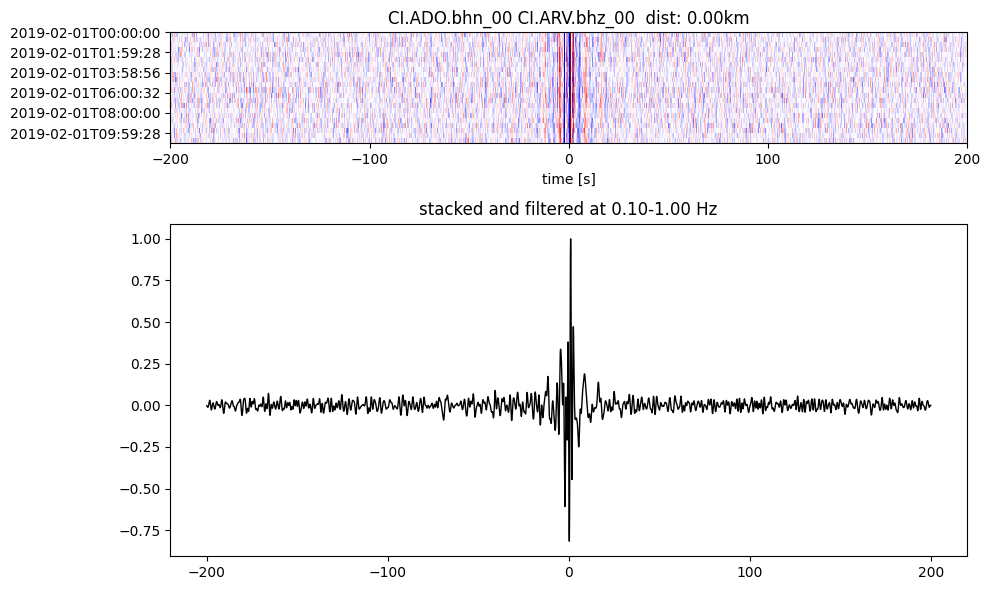

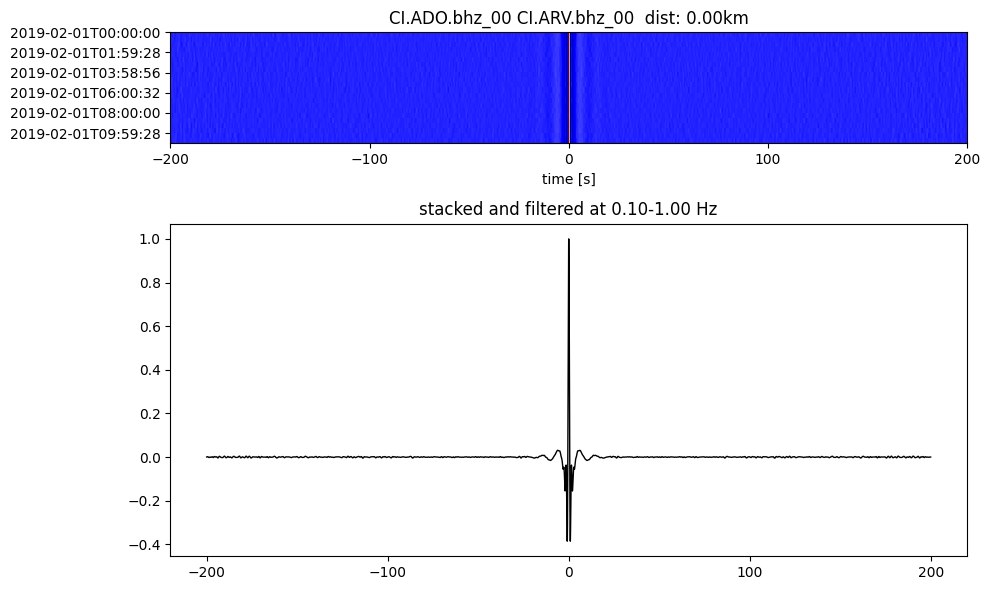

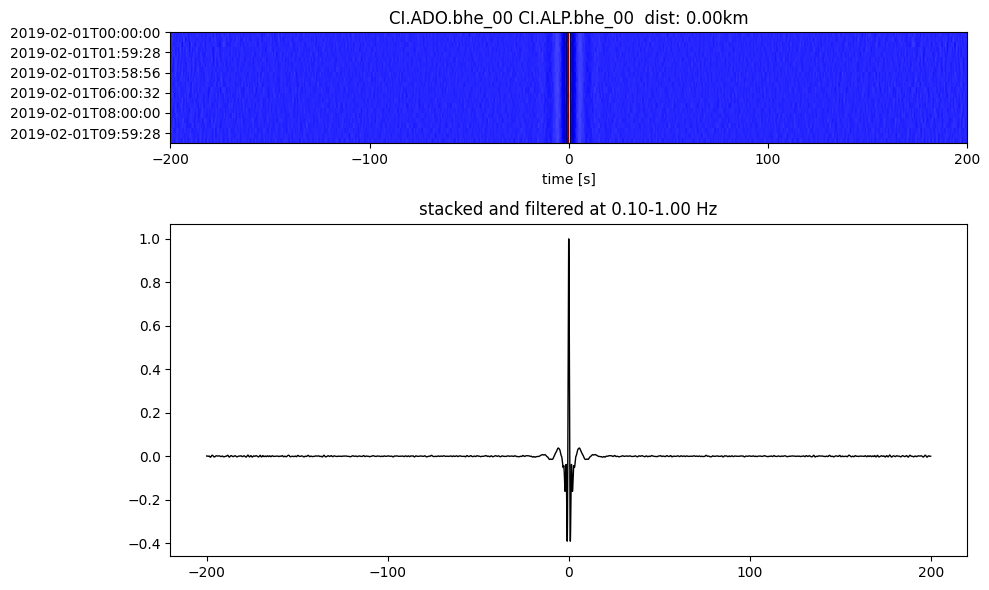

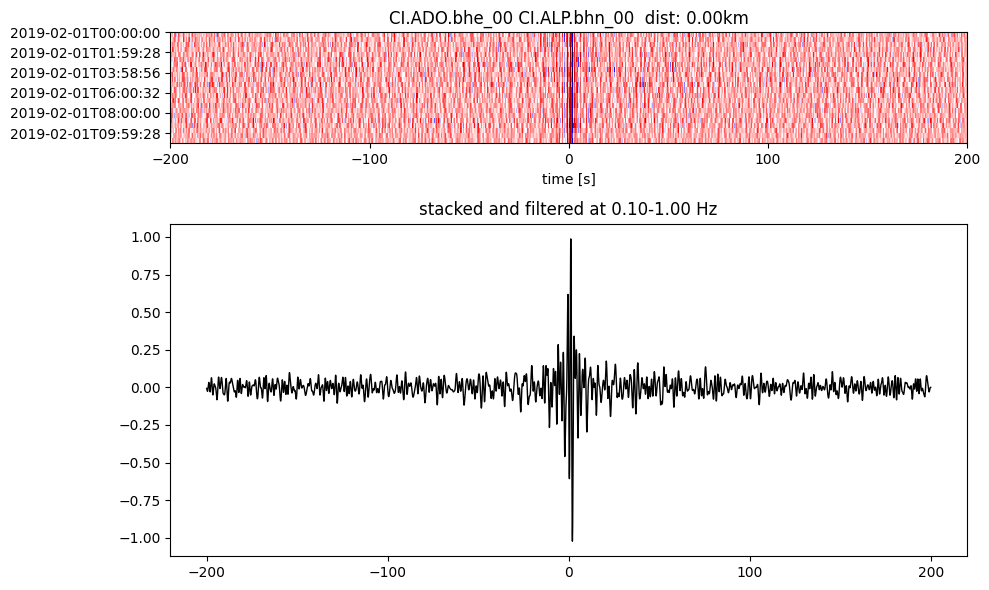

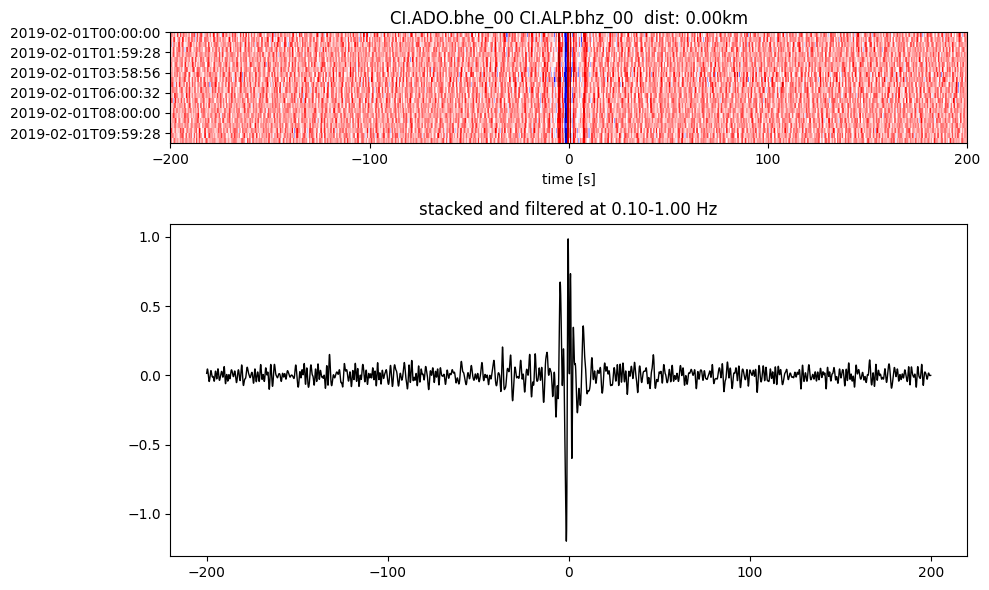

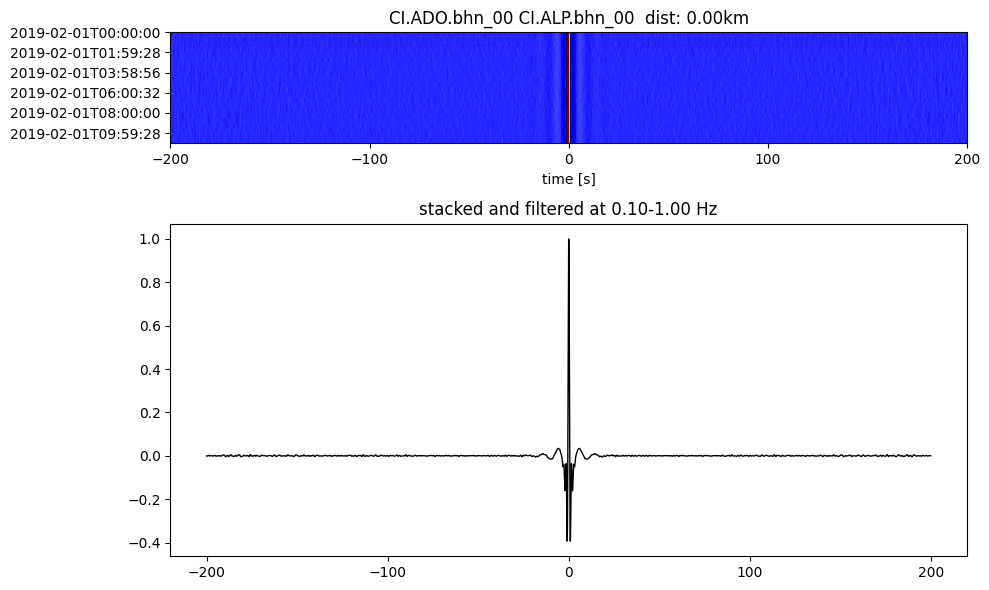

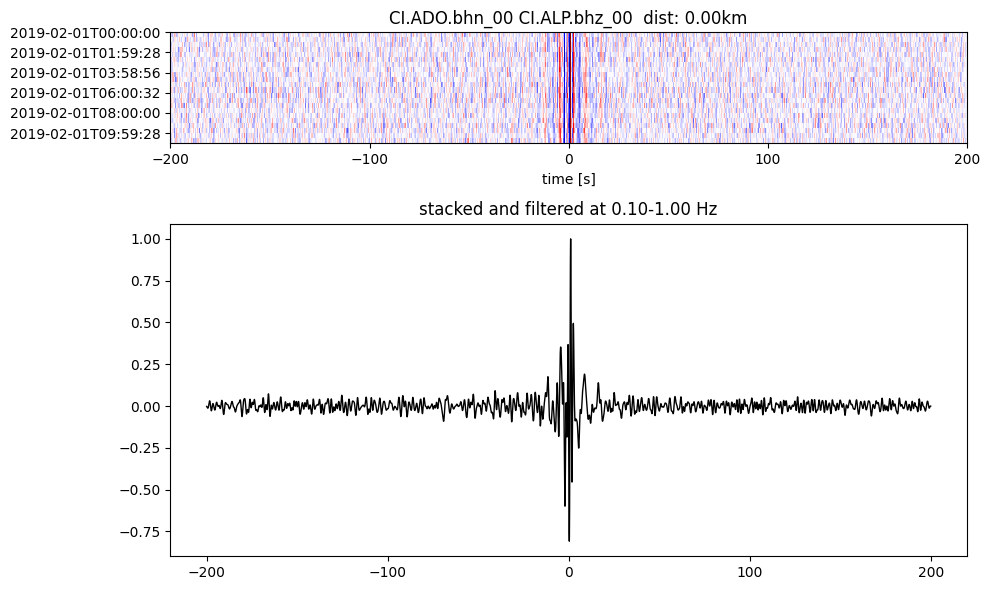

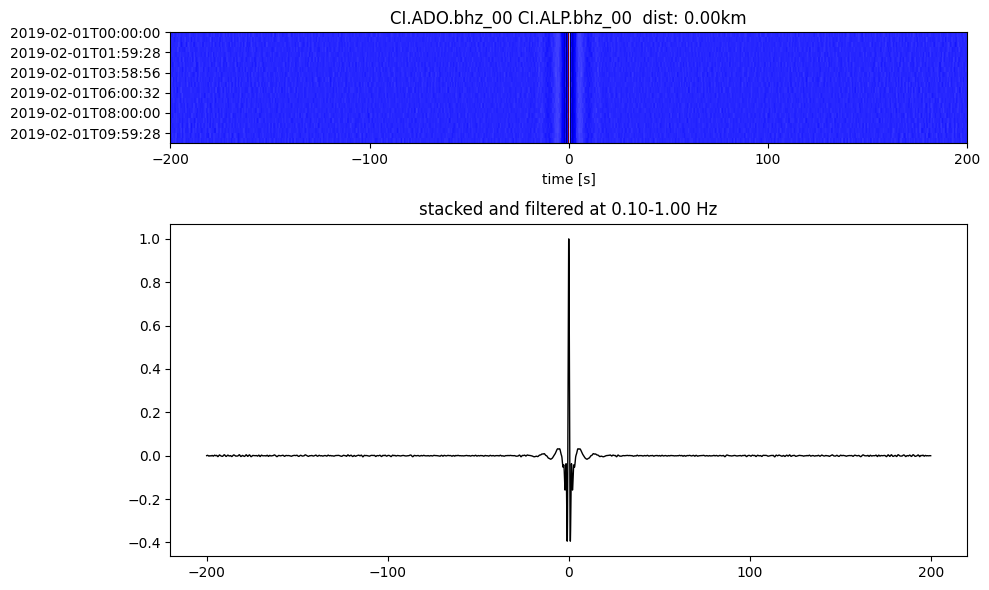

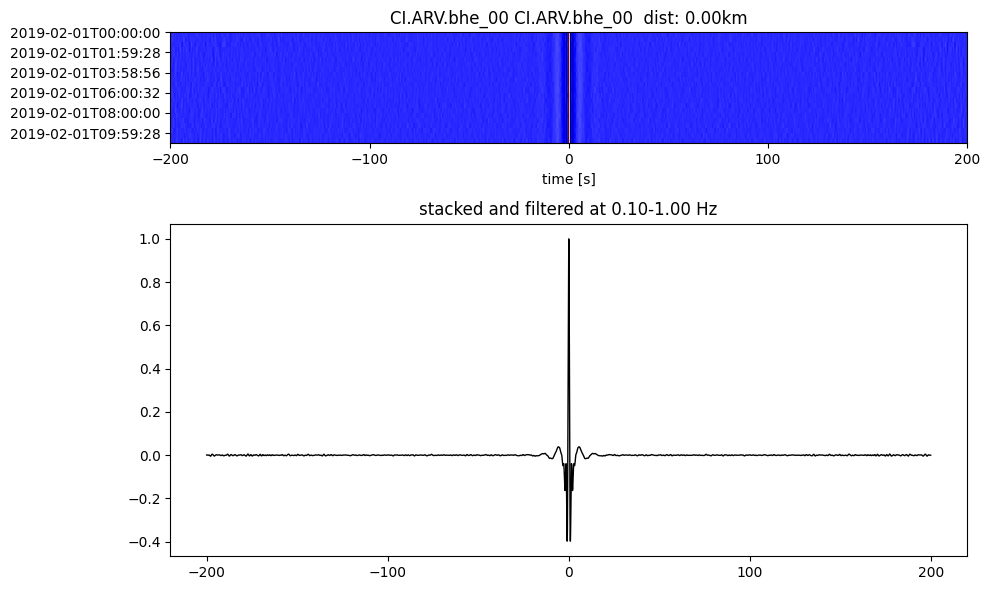

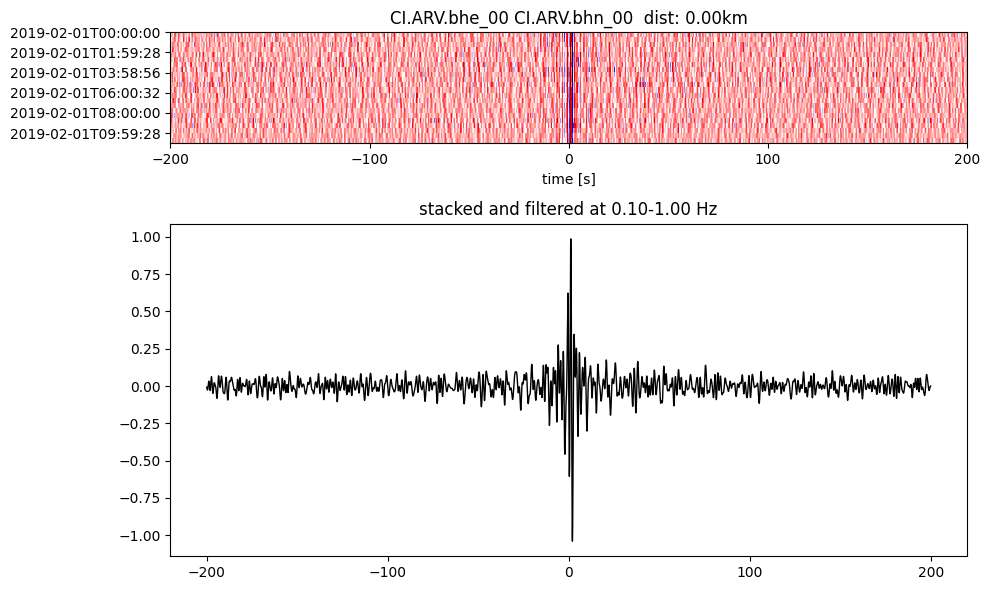

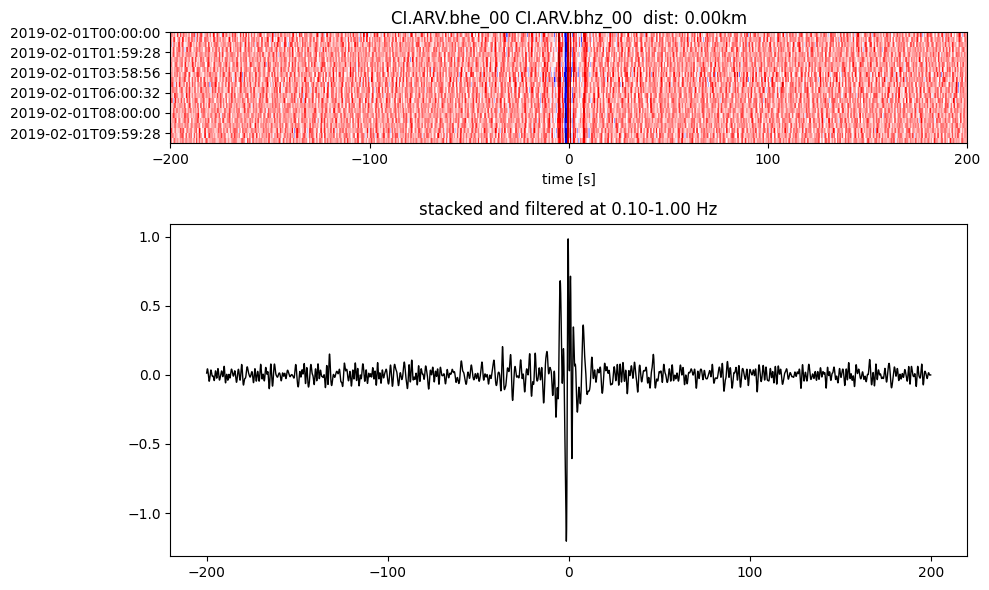

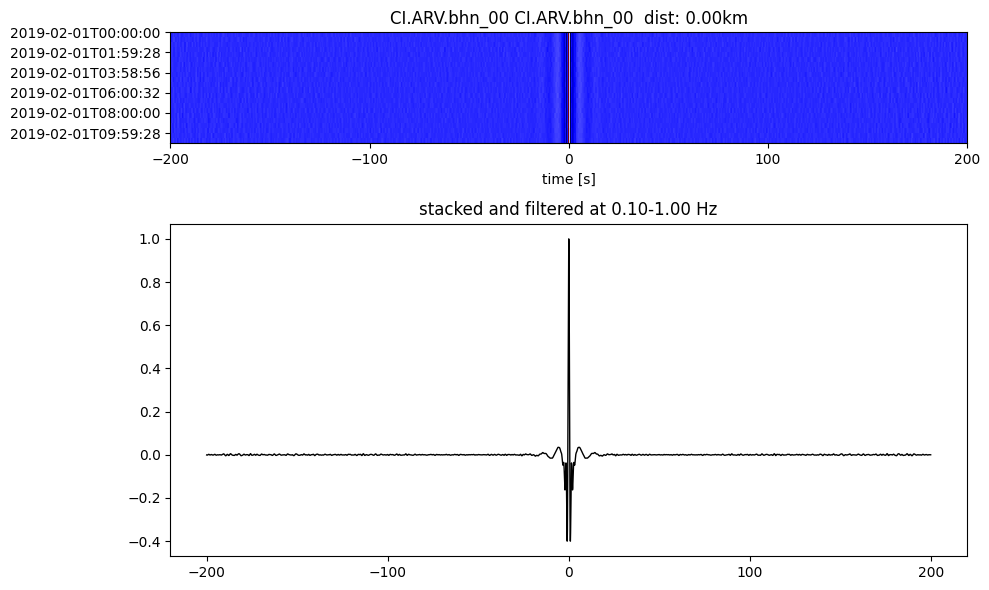

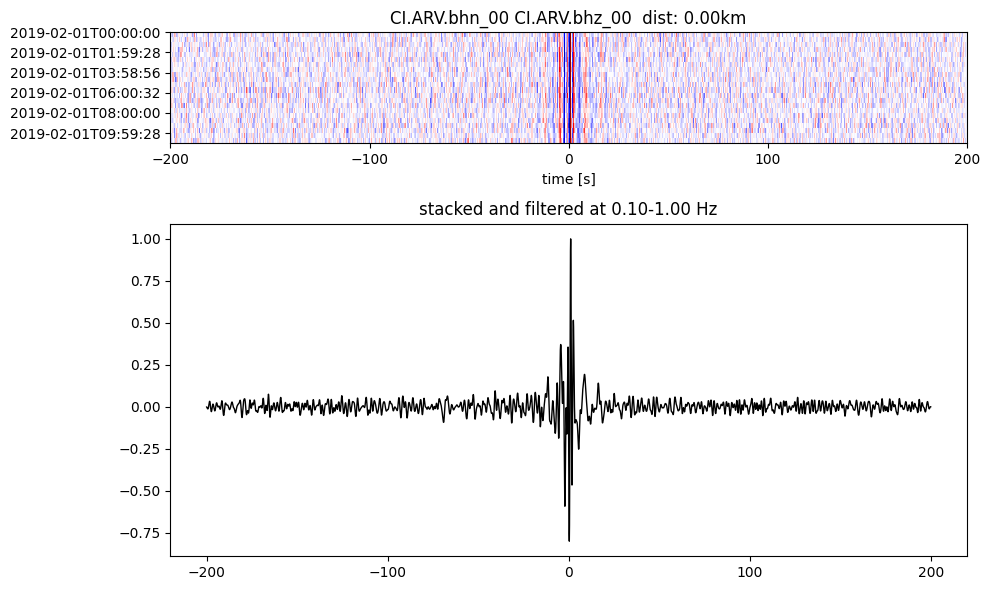

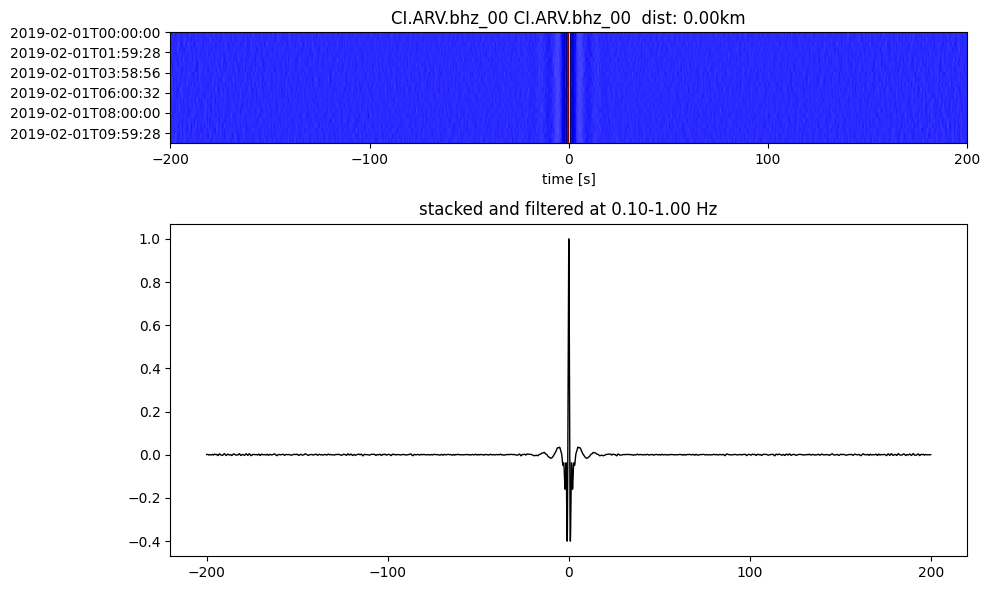

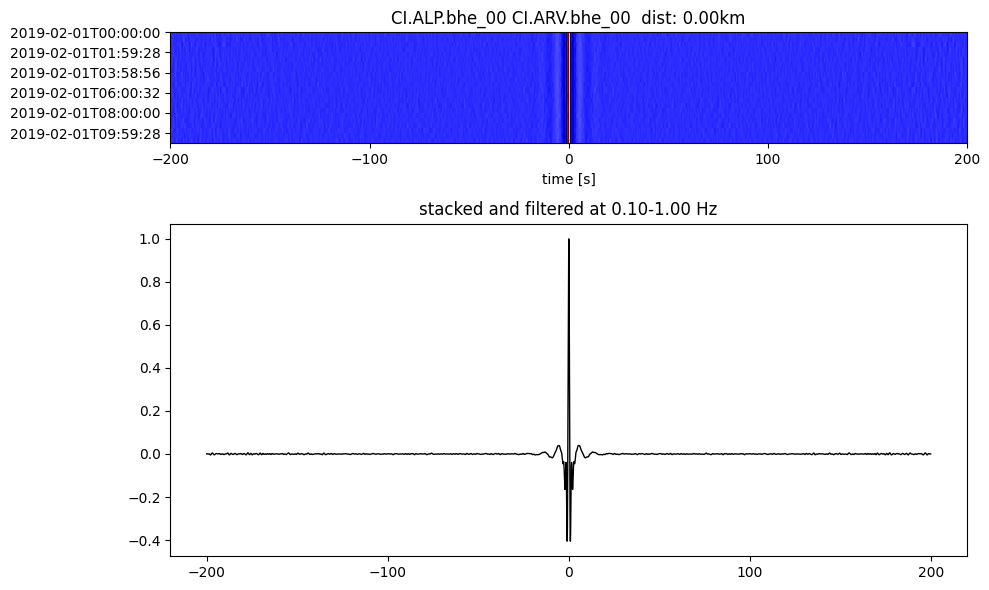

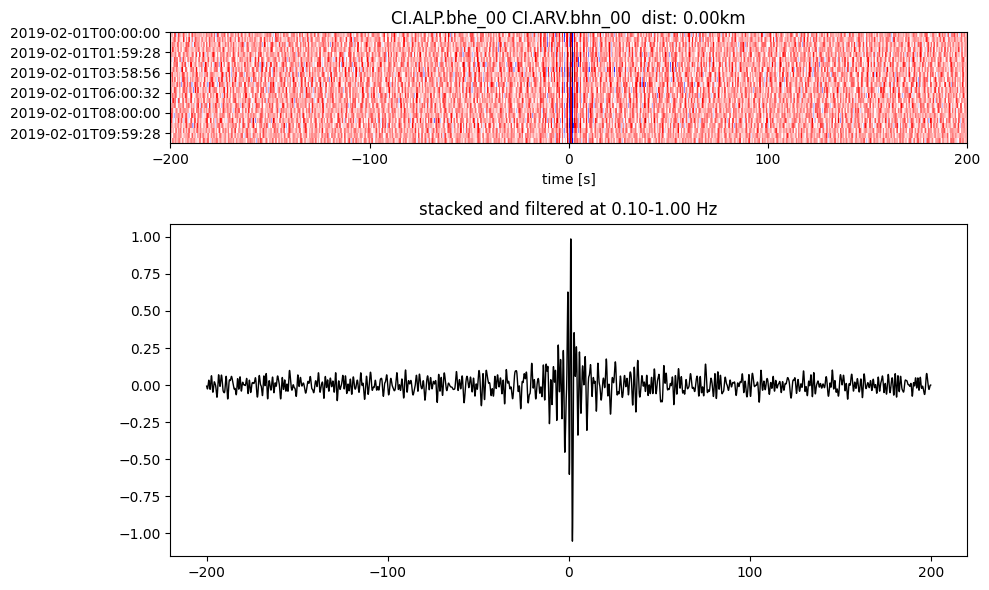

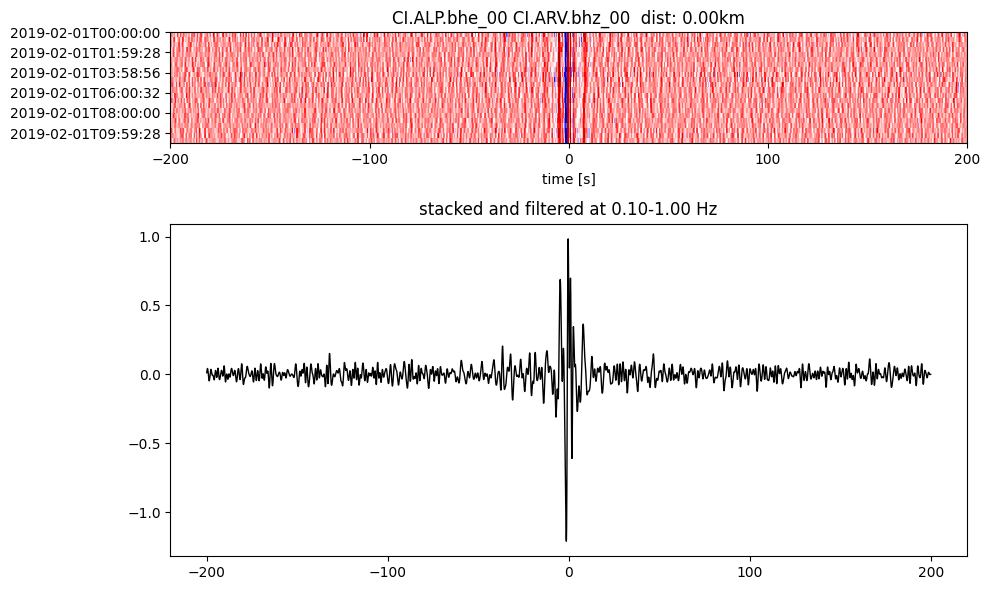

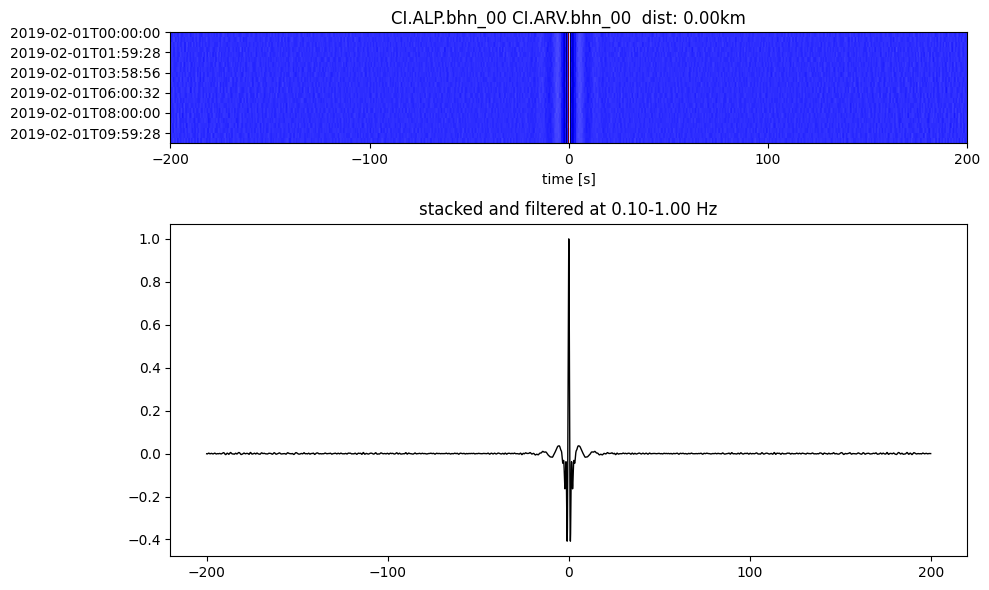

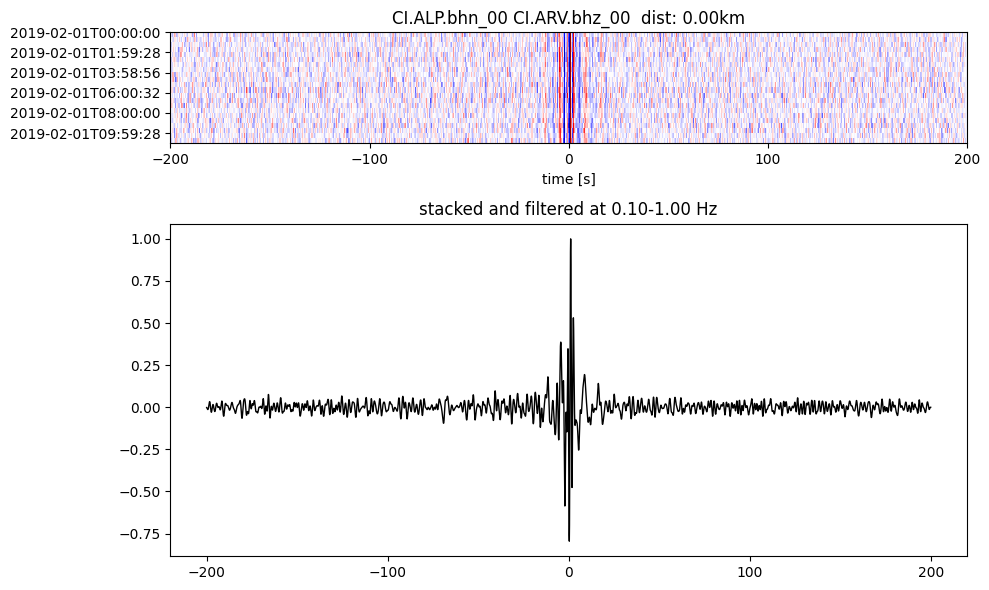

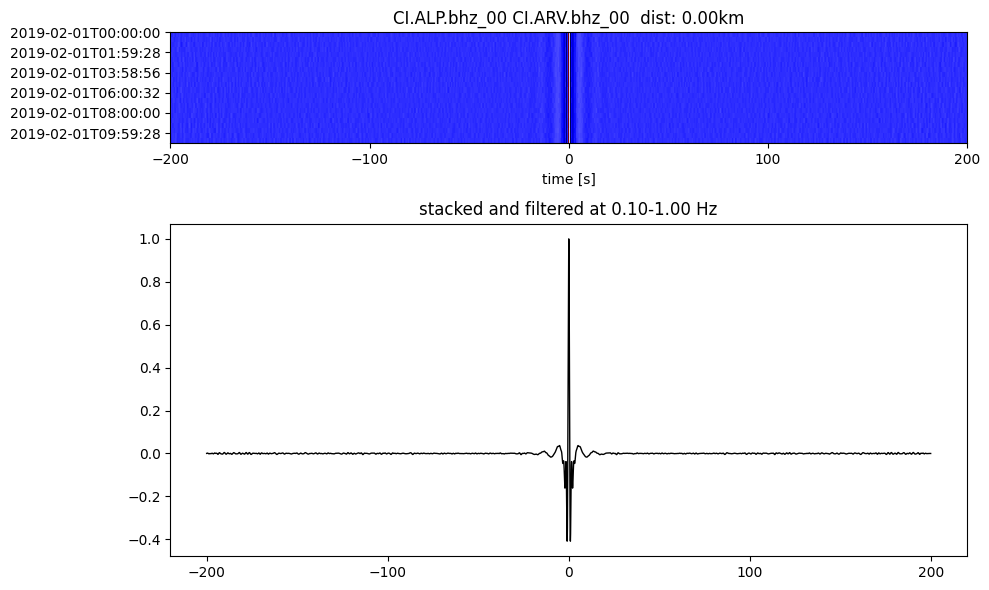

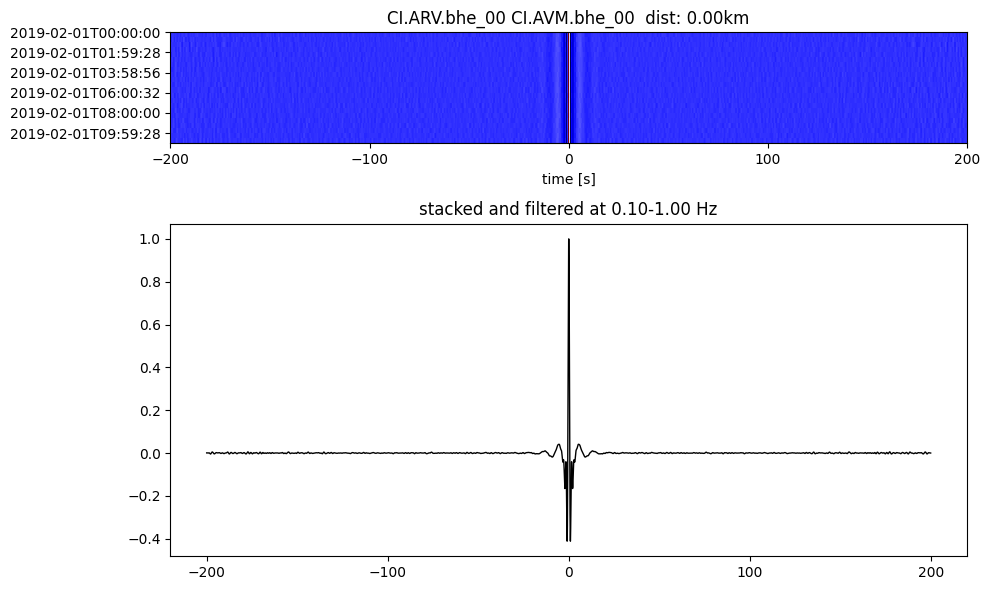

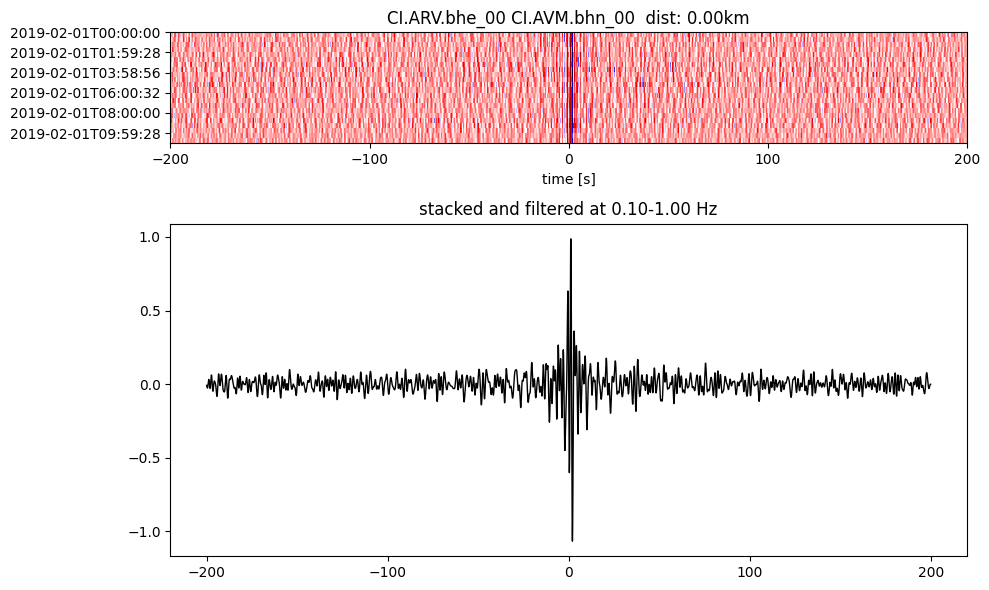

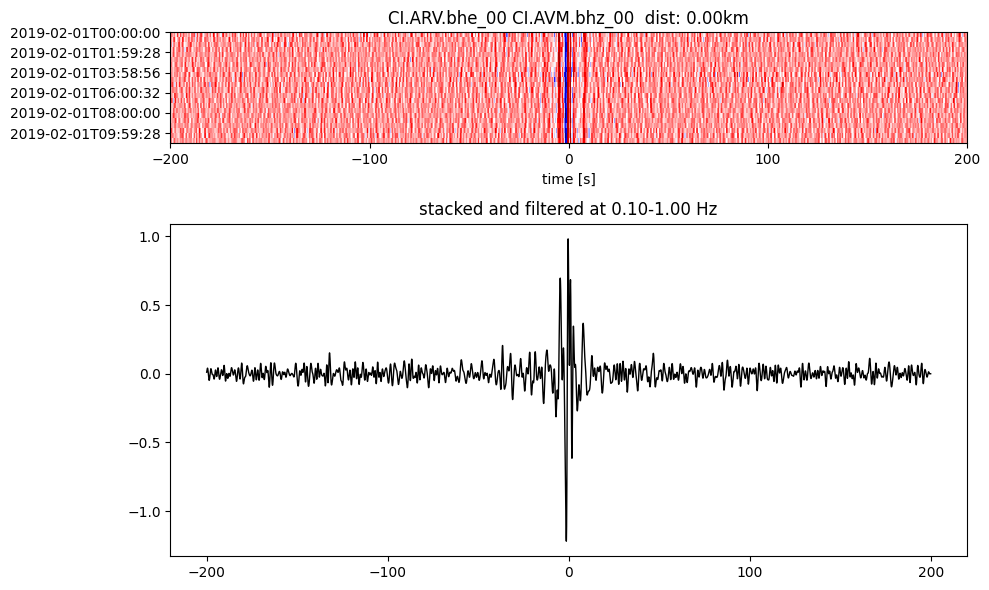

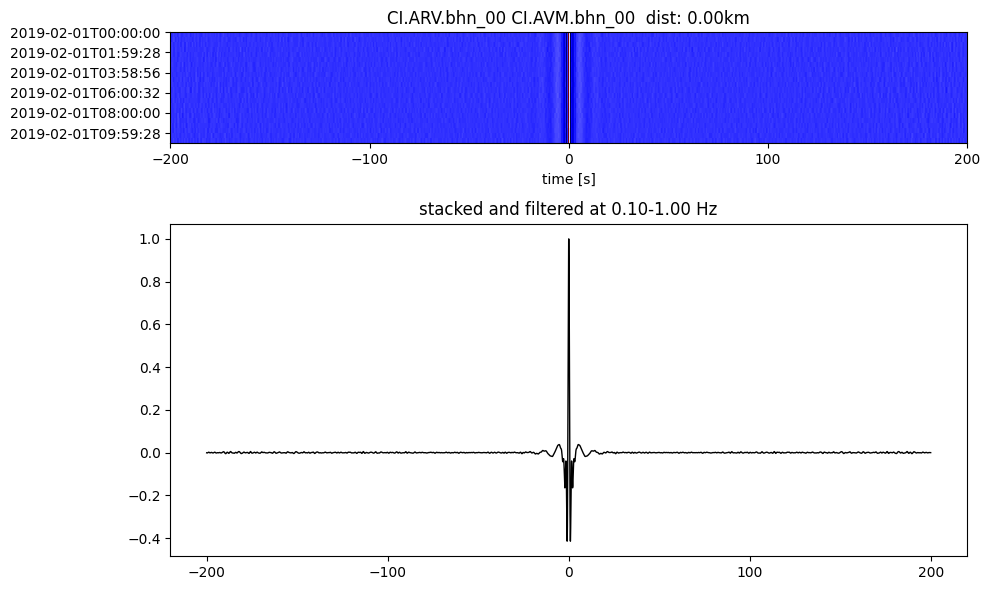

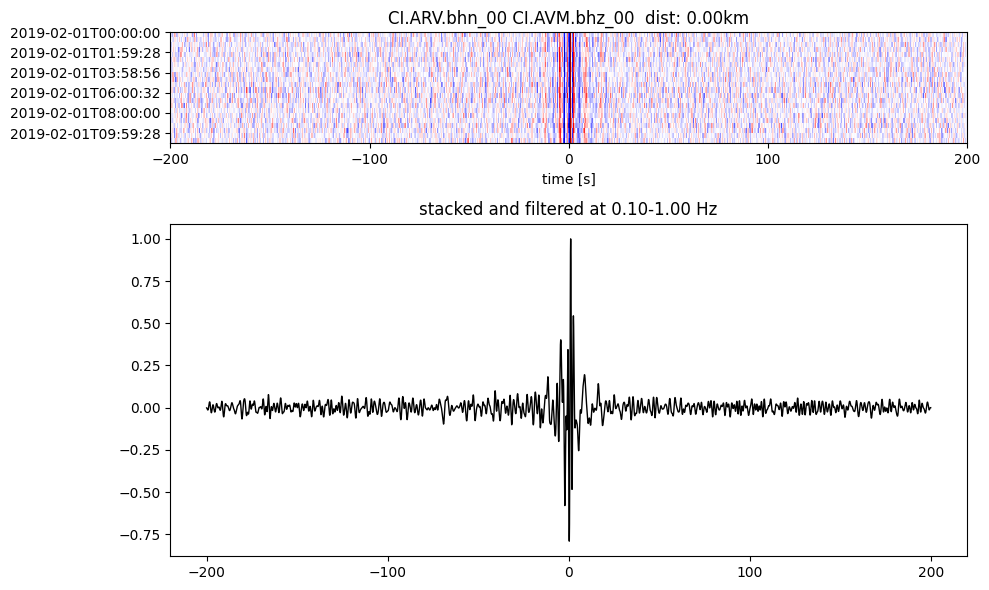

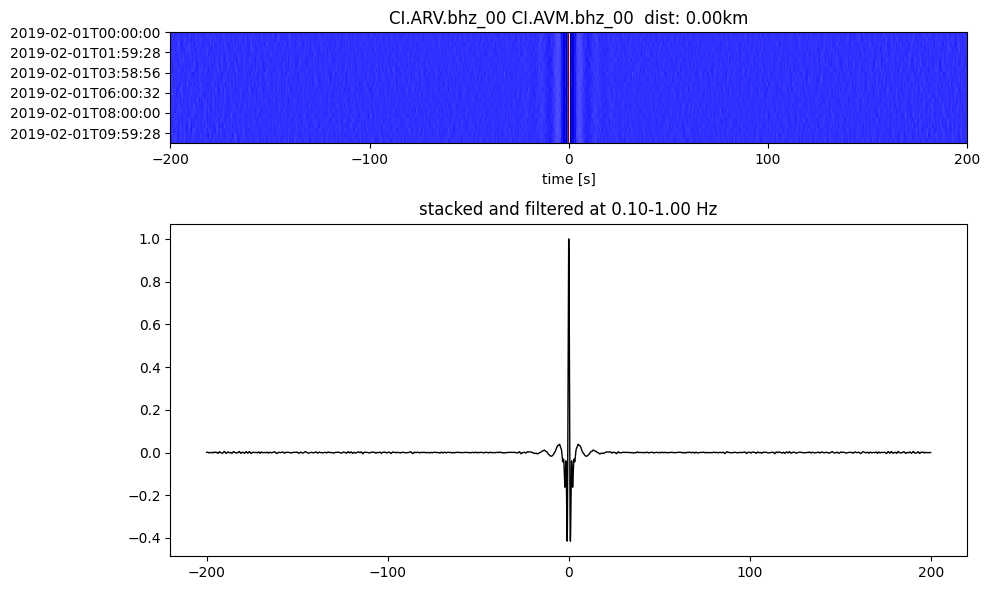

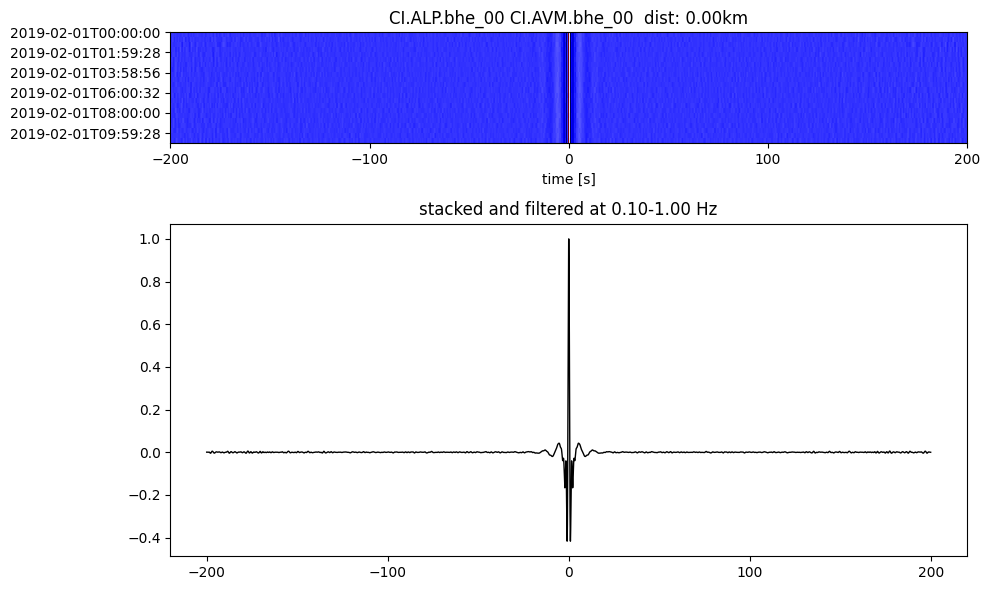

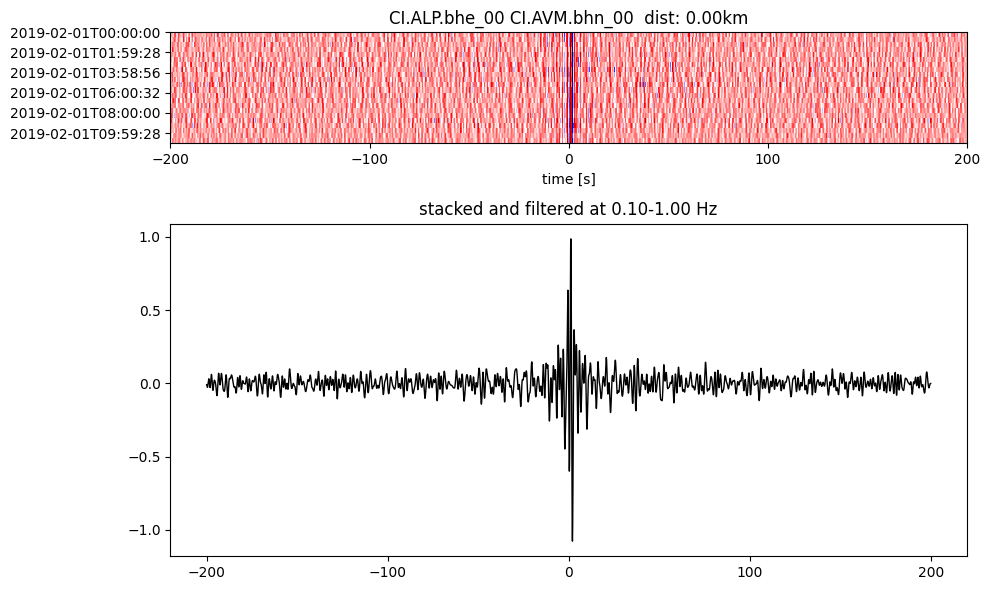

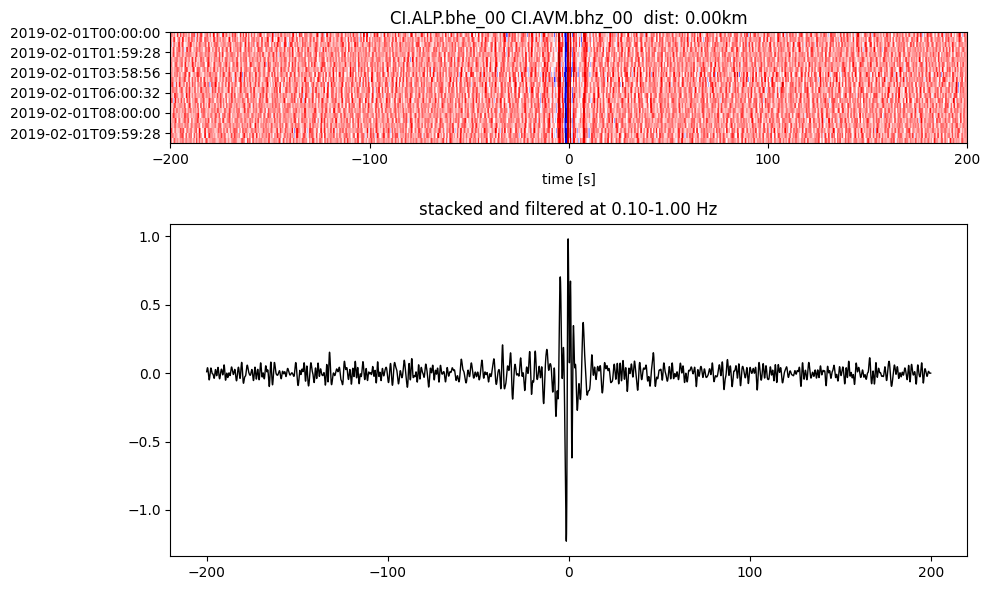

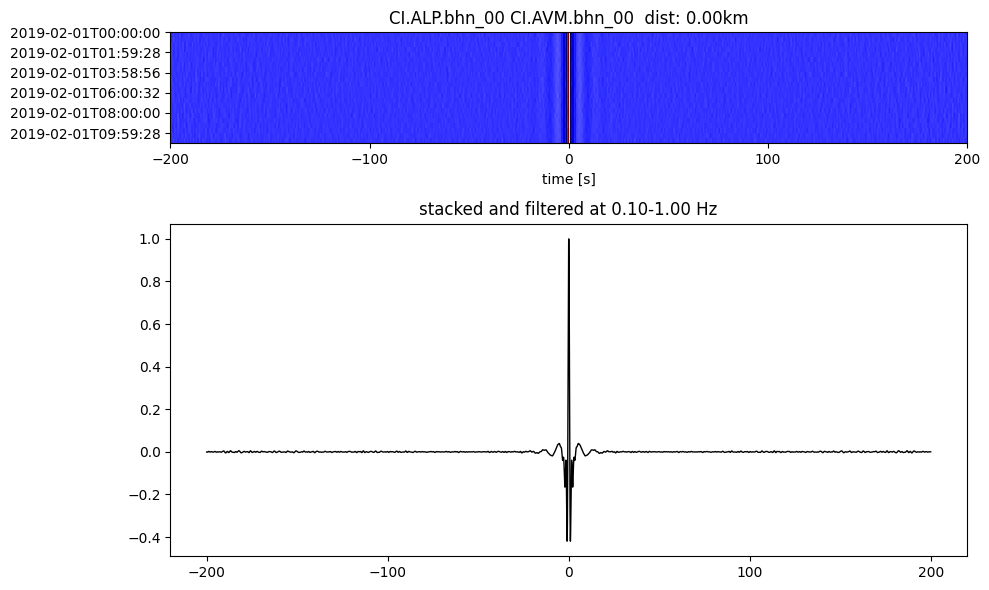

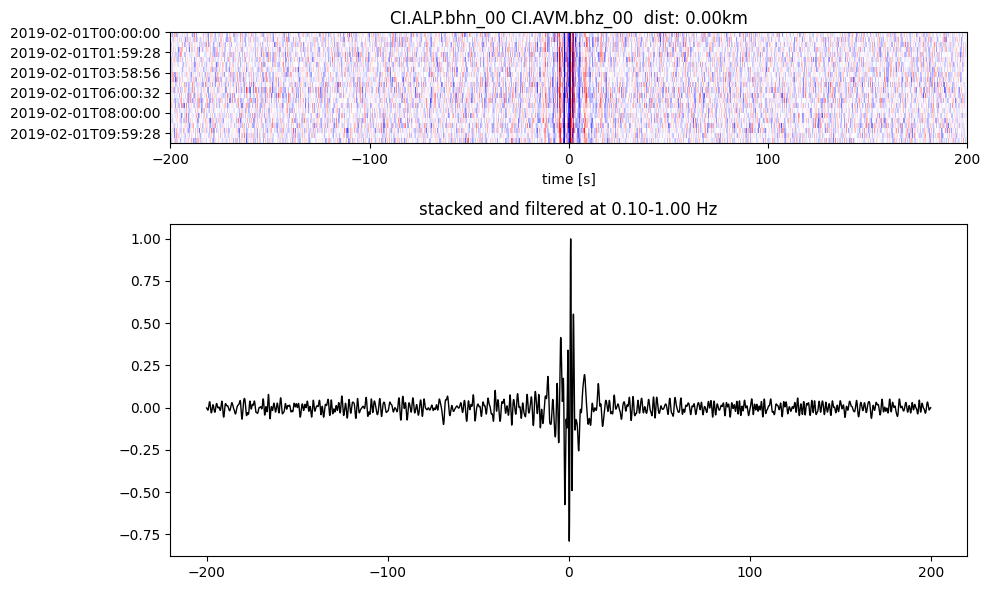

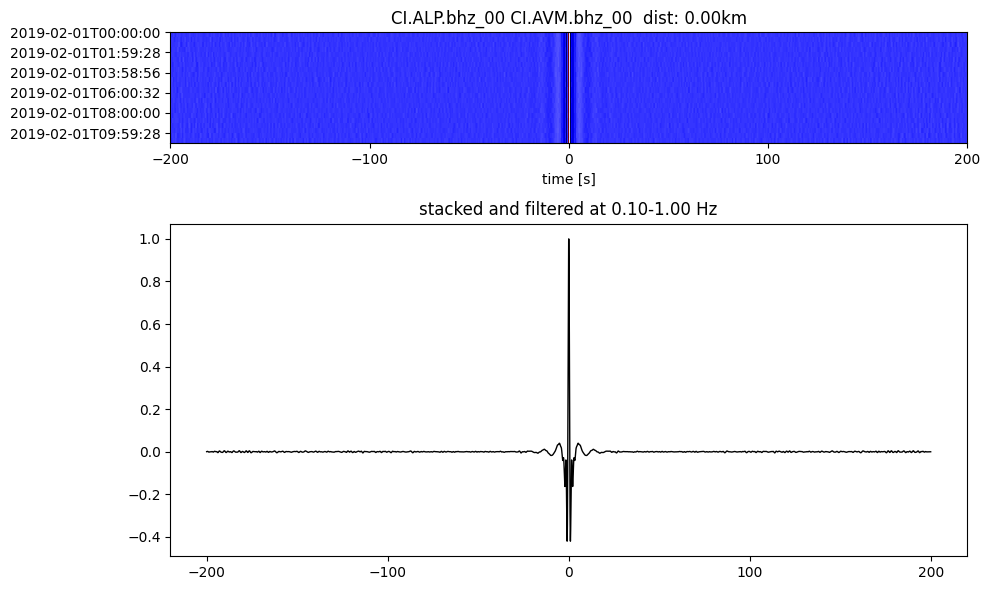

In [10]:
pairs = cc_store.get_station_pairs()
timespans = cc_store.get_timespans(*pairs[0])
plotting_modules.plot_substack_cc(cc_store, timespans[0], 0.1, 1, 200, False)

## Step 2: Stack the cross correlation

This combines the time-chunked ASDF files to stack over each time chunk and at each station pair.

In [11]:
# open a new cc store in read-only mode since we will be doing parallel access for stacking
cc_store = ASDFCCStore(cc_data_path, mode="r")
print(cc_store.get_station_pairs())
stack_store = ASDFStackStore(stack_data_path)
config.stations = ["*"] # stacking doesn't support prefixes yet, so allow all stations
stack_cross_correlations(cc_store, stack_store, config)

2023-11-15 22:46:55,525 19268 INFO stack.initializer(): Station pairs: 10


[(CI.ALP, CI.ALP), (CI.ADO, CI.ADO), (CI.ADO, CI.AVM), (CI.AVM, CI.AVM), (CI.ADO, CI.ARV), (CI.ADO, CI.ALP), (CI.ARV, CI.ARV), (CI.ALP, CI.ARV), (CI.ARV, CI.AVM), (CI.ALP, CI.AVM)]


Stacking Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-15 22:47:12,713 19268 INFO utils.log_raw(): TIMING: 17.1962 secs. for step 2 in total


In [12]:
pairs = stack_store.get_station_pairs()
print(f"Found {len(pairs)} station pairs")
sta_stacks = stack_store.read_bulk(None, pairs) # no timestamp used in ASDFStackStore

Found 10 station pairs


  0%|          | 0/10 [00:00<?, ?it/s]

2023-11-15 22:47:13,551 19268 INFO utils.log_raw(): TIMING: 0.7289 secs. for loading 10 stacks


Plot the stacks

In [13]:
print(os.listdir(cc_data_path))
print(os.listdir(stack_data_path))

['2019_02_01_00_00_00T2019_02_01_12_00_00.h5', '2019_02_01_12_00_00T2019_02_02_00_00_00.h5']
['CI.ADO', 'CI.ALP', 'CI.ARV', 'CI.AVM']


2023-11-15 22:47:13,652 19268 INFO plotting_modules.plot_all_moveout(): Plottting: Allstack_linear, 10 station pairs


200 8001


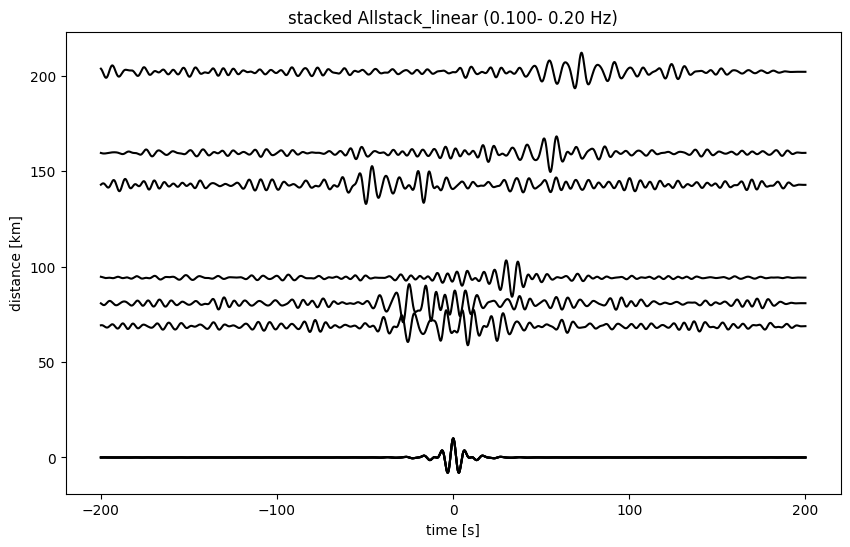

In [14]:
plotting_modules.plot_all_moveout(sta_stacks, 'Allstack_linear', 0.1, 0.2, 'ZZ', 1)